# 使用LayoutLMv3进行自定义数据微调和推理

## 说明

LayoutLMv3模型能够在FUNSD上获得超过90%的F1分数。这得益于使用段位置嵌入，而不是基于单词的位置信息，灵感来自于[StructuralLM](https://arxiv.org/abs/2105.11210)。这意味着属于同一“段”（例如，一个地址）的单词会获得相同的边界框坐标，因此具有相同的二维位置嵌入。

大多数OCR引擎（如谷歌的Tesseract）能够识别段，如LayoutLMv3作者在[这个讨论](https://github.com/microsoft/unilm/issues/838)中所解释的那样。

对于FUNSD数据集，段是根据标签创建的，如[这里](https://huggingface.co/datasets/nielsr/funsd-layoutlmv3/blob/main/funsd-layoutlmv3.py#L140)所示。

始终建议使用段位置嵌入而不是基于单词的位置信息，因为这会显著提高性能。

## 训练提示

请注意，LayoutLMv3在训练/推理方面与LayoutLMv2是相同的，除了以下几点：

* 图像需要被调整大小和归一化，以使其成为形状为 `(batch_size, num_channels, height, width)`的 `pixel_values`。通道需要为RGB格式。这与LayoutLMv2不同，后者期望通道为BGR格式（由于其Detectron2视觉骨干），并在内部对图像进行了归一化。
* 文本的标记化基于RoBERTa，因此使用字节级的字节对编码（Byte-Pair-Encoding）。这与LayoutLMv2使用的BERT风格的WordPiece标记化不同。

因此，我创建了一个新的 `LayoutLMv3Processor`，它将 `LayoutLMv3ImageProcessor`（用于图像模态）和 `LayoutLMv3TokenizerFast`（用于文本模态）结合为一个。用法与其前身[`LayoutLMv2Processor`](https://huggingface.co/docs/transformers/model_doc/layoutlmv2#usage-layoutlmv2processor)相同。

## 环境设置
1. MindSpore 2.4.10
2. Mindnlp 0.4.1
3. Python 3.9



**使用华为云 ModelArts 作为AI平台**

在环境搭建部分，使用了AI gallery社区中相关mindnlp项目搭建mindnlp环境的代码。

### 环境配置

配置python3.9环境

In [ ]:
%%capture captured_output

# 安装python 3.9版本的kernel
!/home/ma-user/anaconda3/bin/conda create -n python-3.9.0 python=3.9.0 -y --override-channels --channel https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
!/home/ma-user/anaconda3/envs/python-3.9.0/bin/pip install ipykernel

In [ ]:
import json
import os

data = {
   "display_name": "python-3.9.0",
   "env": {
      "PATH": "/home/ma-user/anaconda3/envs/python-3.9.0/bin:/home/ma-user/anaconda3/envs/python-3.7.10/bin:/modelarts/authoring/notebook-conda/bin:/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/ma-user/modelarts/ma-cli/bin:/home/ma-user/modelarts/ma-cli/bin"
   },
   "language": "python",
   "argv": [
      "/home/ma-user/anaconda3/envs/python-3.9.0/bin/python",
      "-m",
      "ipykernel",
      "-f",
      "{connection_file}"
   ]
}

if not os.path.exists("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/"):
    os.mkdir("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/")

with open('/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/kernel.json', 'w') as f:
    json.dump(data, f, indent=4)

*注：以上代码执行完成后，需点击左上角或右上角将kernel更换为python-3.9.0*

2. 安装mindspore2.4.10，安装指南详见：[MindSpore安装](https://www.mindspore.cn/install/)

3. 安装MindNLP及相关依赖，MindNLP官方仓详见：[MindNLP](https://github.com/mindspore-lab/mindnlp)

创建完成后，稍等片刻，或刷新页面，点击右上角（或左上角）kernel选择python-3.9

安装python依赖

In [ ]:
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/2.4.10/MindSpore/unified/aarch64/mindspore-2.4.10-cp310-cp310-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install mindnlp==0.4.1

In [1]:
!pip show mindspore
!pip show mindnlp

Name: mindspore
Version: 2.4.10
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /root/miniconda3/lib/python3.10/site-packages
Requires: asttokens, astunparse, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: mindnlp
Name: mindnlp
Version: 0.4.1
Summary: An open source natural language processing research tool box. Git version: [sha1]:22221f40, [branch]: (HEAD -> master, tag: v0.4.1, origin/master)
Home-page: https://github.com/mindlab-ai/mindnlp/tree/master/
Author: MindSpore Team
Author-email: 
License: Apache 2.0
Location: /root/miniconda3/lib/python3.10/site-packages
Requires: addict, datasets, evaluate, mindspore, ml-dtypes, pillow, pyctcdecode, pytest, regex, requests, safetensors, sentencepiece, tokenizers, tqdm
Required-by: 


In [2]:
!pip install seqeval

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [ ]:
import mindspore

mindspore.context.get_context('device_target')

## 加载数据集

接下来，我们从 🤗 [hub](https://huggingface.co/datasets/nielsr/funsd-layoutlmv3) 加载一个数据集。这个数据集是 [FUNSD](https://guillaumejaume.github.io/FUNSD/) 数据集，包含了一系列带注释的表单。


In [4]:
!git clone https://github.com/wjy4399/funsd-layoutlmv3

fatal: destination path 'funsd-layoutlmv3' already exists and is not an empty directory.


In [5]:
from mindnlp.dataset import load_dataset 

# this dataset uses the new Image feature :)
dataset = load_dataset("funsd-layoutlmv3")

In [6]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

正如我们所见，数据集由2个拆分部分组成（"训练集"和"测试集"），每个样本都包含一个单词列表（"tokens"）及其对应的边界框（"bboxes"），而且这些单词都被标记了（"ner_tags"）。每个样本还包括原始图像（"image"）。

In [7]:
example = next(train_dataset.create_dict_iterator())
print(example)

{'id': Tensor(shape=[], dtype=String, value= '0'), 'tokens': Tensor(shape=[145], dtype=String, value= ['R&D', ':', 'Suggestion:', 'Date:', 'Licensee', 'Yes', 'No', '597005708',
 'R&D', 'QUALITY', 'IMPROVEMENT', 'SUGGESTION/', 'SOLUTION', 'FORM',
 'Name', '/', 'Phone', 'Ext.', ':', 'M.', 'Hamann', 'P.', 'Harper,', 'P.',
 'Martinez', '9/', '3/', '92', 'R&D', 'Group:', 'J.', 'S.', 'Wigand',
 'Supervisor', '/', 'Manager', 'Discontinue', 'coal', 'retention',
 'analyses', 'on', 'licensee', 'submitted', 'product', 'samples', '(Note',
 ':', 'Coal', 'Retention', 'testing', 'is', 'not', 'performed', 'by',
 'most', 'licensees.', 'Other', 'B&W', 'physical', 'measurements', 'as',
 'ends', 'stability', 'and', 'inspection', 'for', 'soft', 'spots', 'in',
 'ciparettes', 'are', 'thought', 'to', 'be', 'sufficient', 'measures',
 'to', 'assure', 'cigarette', 'physical', 'integrity.', 'The', 'proposed',
 'action', 'will', 'increase', 'laboratory', 'productivity', '.', ')',
 'Suggested', 'Solutions', '(s)', 

查看示例

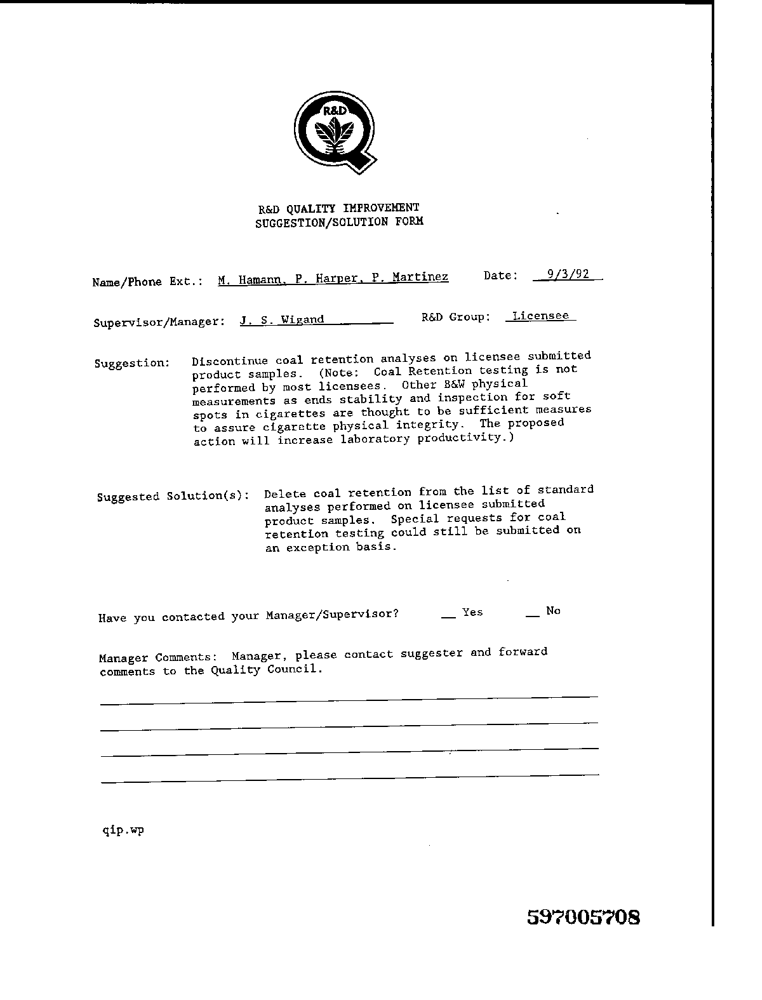

In [8]:
from PIL import Image
import io
image = example['image'].asnumpy()
image = Image.fromarray(image, 'RGB')
# 显示图片
image.show()

In [9]:
words, boxes, ner_tags = example["tokens"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['R&D' ':' 'Suggestion:' 'Date:' 'Licensee' 'Yes' 'No' '597005708' 'R&D'
 'QUALITY' 'IMPROVEMENT' 'SUGGESTION/' 'SOLUTION' 'FORM' 'Name' '/'
 'Phone' 'Ext.' ':' 'M.' 'Hamann' 'P.' 'Harper,' 'P.' 'Martinez' '9/' '3/'
 '92' 'R&D' 'Group:' 'J.' 'S.' 'Wigand' 'Supervisor' '/' 'Manager'
 'Discontinue' 'coal' 'retention' 'analyses' 'on' 'licensee' 'submitted'
 'product' 'samples' '(Note' ':' 'Coal' 'Retention' 'testing' 'is' 'not'
 'performed' 'by' 'most' 'licensees.' 'Other' 'B&W' 'physical'
 'measurements' 'as' 'ends' 'stability' 'and' 'inspection' 'for' 'soft'
 'spots' 'in' 'ciparettes' 'are' 'thought' 'to' 'be' 'sufficient'
 'measures' 'to' 'assure' 'cigarette' 'physical' 'integrity.' 'The'
 'proposed' 'action' 'will' 'increase' 'laboratory' 'productivity' '.' ')'
 'Suggested' 'Solutions' '(s)' ':' 'Delete' 'coal' 'retention' 'from'
 'the' 'list' 'of' 'standard' 'analyses' 'performed' 'on' 'licensee'
 'submitted' 'product' 'samples.' 'Special' 'requests' 'for' 'coal'
 'retention' 'testin

## 准备数据集

接下来，我们为模型准备数据集。这可以使用`LayoutLMv3Processor`非常轻松地完成，它在内部将`LayoutLMv3FeatureExtractor`（用于图像模态）和`LayoutLMv3Tokenizer`（用于文本模态）包装在一起。

基本上，处理器在内部执行以下操作：
* 特征提取器用于将每个文档图像调整大小并归一化为`pixel_values`
* 分词器用于将单词、边界框和NER标签转换为标记级别的`input_ids`、`attention_mask`和`labels`。

处理器简单地返回一个包含所有这些键的字典。


In [10]:
from mindnlp.transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

/root/miniconda3/lib/python3.10/site-packages/mindnlp/transformers/tokenization_utils_base.py:1526: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted, and will be then set to `False` by default. 
  warnings.warn(


我们首先创建id2label和label2id映射，这对推理很有用。请注意，LayoutLMv3ForTokenClassification（我们稍后将使用的模型）将简单地为每个标记输出一个特定类别的整数索引，因此我们仍然需要将其映射到实际的类别名称。

In [11]:
# 2. 定义列名和标签映射
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"
# 定义标签映射
label_list = ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']
id2label = {i: name for i, name in enumerate(label_list)}
label2id = {name: i for i, name in enumerate(label_list)}
num_labels = len(label_list)

In [12]:
print(label_list)

['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [13]:
print(id2label)

{0: 'O', 1: 'B-HEADER', 2: 'I-HEADER', 3: 'B-QUESTION', 4: 'I-QUESTION', 5: 'B-ANSWER', 6: 'I-ANSWER'}


接下来，我们将定义一个可以应用于整个数据集的函数。

In [14]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [15]:

class FUNSDDataset:
    """FUNSD数据集的自定义处理类"""

    def __init__(self, dataset, processor, max_length=512):
        """
        Args:
            dataset: MindNLP加载的数据集
            processor: LayoutLMv3的处理器
            max_length: 序列最大长度
        """
        self.dataset = dataset
        self.processor = processor
        self.max_length = max_length
        
        # 提取所有需要的数据
        self.images = []
        self.tokens = []
        self.boxes = []
        self.labels = []
        
        # 加载所有样本
        for item in self.dataset.create_dict_iterator():
            self.images.append(item[image_column_name].asnumpy())
            self.tokens.append(item[text_column_name].asnumpy().tolist())
            self.boxes.append(item[boxes_column_name].asnumpy().tolist())
            self.labels.append(item[label_column_name].asnumpy().tolist())
        
        # 预处理所有数据
        self.encoded_inputs_list = []
        self.__process_all_samples__()
    
    def __process_all_samples__(self):
        """预处理所有样本"""
        for idx in range(self.__len__()):
            # 获取单个样本
            image = self.images[idx]
            words = self.tokens[idx]
            boxes = self.boxes[idx]
            word_labels = self.labels[idx]
            
            # 确保数据长度一致
            assert len(words) == len(boxes) == len(word_labels)
            
            # 使用处理器预处理
            encoded_inputs = self.processor(
                image, 
                words, 
                boxes=boxes, 
                word_labels=word_labels,
                truncation=True, 
                padding="max_length", 
                max_length=self.max_length,
                return_tensors="np"
            )
            
            # 去除批处理维度
            for k, v in encoded_inputs.items():
                encoded_inputs[k] = v.squeeze()
            
            # 存储为元组，适配MindSpore的GeneratorDataset
            self.encoded_inputs_list.append((
                encoded_inputs["pixel_values"],
                encoded_inputs["input_ids"],
                encoded_inputs["attention_mask"],
                encoded_inputs["bbox"],
                encoded_inputs["labels"]
            ))

    def __len__(self):
        """返回数据集长度"""
        return len(self.images)

    def __getitem__(self, idx):
        """获取单个样本"""
        return self.encoded_inputs_list[idx]

In [16]:
# 使用MindSpore的数据处理方式
from mindspore.dataset import GeneratorDataset

# 创建自定义数据集实例
train_funsd_dataset = FUNSDDataset(dataset["train"], processor)
eval_funsd_dataset = FUNSDDataset(dataset["test"], processor)

In [26]:
# 定义列名
column_names = ["pixel_values", "input_ids", "attention_mask", "bbox", "labels"]

# 创建MindSpore数据集
def create_ms_dataset(custom_dataset, batch_size=2, shuffle=True):
    """创建MindSpore数据集"""
    ms_dataset = GeneratorDataset(
        source=custom_dataset,
        column_names=column_names,
        shuffle=shuffle
    )
    
    # 批处理
    ms_dataset = ms_dataset.batch(batch_size)
    
    return ms_dataset

In [27]:
# 创建最终的数据集
train_dataset = create_ms_dataset(train_funsd_dataset)
eval_dataset = create_ms_dataset(eval_funsd_dataset)


让我们验证一下所有内容是否正确创建：

In [28]:
# 展示处理后的样本
first_batch = next(train_dataset.create_dict_iterator())
print("训练样本数量:", len(train_funsd_dataset))
print("处理后的数据形状:")
for key, value in first_batch.items():
    print(f"  {key}: {value.shape}")


训练样本数量: 149
处理后的数据形状:
  pixel_values: (2, 3, 224, 224)
  input_ids: (2, 512)
  attention_mask: (2, 512)
  bbox: (2, 512, 4)
  labels: (2, 512)


In [29]:
# 解码第一个样本的input_ids
decoded_text = processor.tokenizer.decode(first_batch["input_ids"][0].asnumpy())
print("\n解码后的文本示例:\n", decoded_text[:200] + "...")


解码后的文本示例:
 <s> B&W WCC 621800455 Reconstituted Tobacco Leaf Substitutions Export Formulas Revision Date: Allowable Grade Substitutions for Export CPCL Standard Grade Mark Allowable Substitutions PCFS Flue cured ...


## 定义模型

接下来，我们定义模型：这是一个带有预训练权重的 Transformer 编码器，顶部有一个随机初始化的头用于标记分类。


In [30]:
from mindnlp.transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained(
        "microsoft/layoutlmv3-base",
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
model

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

In [32]:
print(type(model))

<class 'mindnlp.transformers.models.layoutlmv3.modeling_layoutlmv3.LayoutLMv3ForTokenClassification'>


## 创建梯度计算函数

接下来，我们定义 `TrainingArguments`，它定义了与训练相关的所有超参数。请注意，有大量参数可以调整，更多信息请查看 [文档](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments)。


In [33]:
from mindnlp.core.optim import AdamW
optimizer = AdamW(model.trainable_params(), lr=1e-5)

from mindnlp.core.autograd import value_and_grad

def forward_fn(batch):
    """
    前向传播函数
    
    Args:
        batch: 一个批次的数据，包含输入和标签
        
    Returns:
        loss: 模型计算的损失值
    """
    # 获取输入
    input_ids = batch['input_ids']
    bbox = batch['bbox']
    pixel_values = batch['pixel_values']  # LayoutLMv3使用pixel_values而不是image
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    
    # token_type_ids在我们的数据集中可能不存在，所以不传入
    outputs = model(
        input_ids=input_ids,
        bbox=bbox,
        pixel_values=pixel_values,  # 使用pixel_values
        attention_mask=attention_mask,
        labels=labels
    ) 
    
    loss = outputs.loss
    return loss

# 创建梯度计算函数
grad_fn = value_and_grad(forward_fn, model.trainable_params(), attach_grads=True)

## 训练模型

In [34]:
from tqdm import tqdm

# put the model in training mode
model.set_train(True)
global_step = 0
num_train_epochs = 10
epoch=0
# 计算每个epoch的步数
train_size = len(train_funsd_dataset)  # 数据集大小
batch_size = 2  # 批处理大小(默认值)
steps_per_epoch = (train_size + batch_size - 1) // batch_size  # 向上取整

for epoch in range(num_train_epochs):  
    print("Epoch:", epoch)
    for batch in tqdm(train_dataset.create_dict_iterator(), total=steps_per_epoch):
        optimizer.zero_grad()
        # forward, backward + optimize
        loss = grad_fn(batch)
        optimizer.step()


        # print loss every 100 steps
        if global_step % 1 == 0:
            print(f"Loss after {global_step} steps: {loss.item()}")

        global_step += 1

Epoch: 0


  0%|          | 0/75 [00:00<?, ?it/s]

.

  1%|▏         | 1/75 [00:11<14:11, 11.51s/it]

Loss after 0 steps: 2.058302402496338


  3%|▎         | 2/75 [00:12<06:08,  5.05s/it]

Loss after 1 steps: 1.898685097694397


  4%|▍         | 3/75 [00:12<03:33,  2.97s/it]

Loss after 2 steps: 2.2574238777160645


  5%|▌         | 4/75 [00:13<02:20,  1.98s/it]

Loss after 3 steps: 1.8202344179153442


  7%|▋         | 5/75 [00:13<01:40,  1.44s/it]

Loss after 4 steps: 1.9581518173217773


  8%|▊         | 6/75 [00:13<01:16,  1.11s/it]

Loss after 5 steps: 1.745012879371643


  9%|▉         | 7/75 [00:14<01:01,  1.11it/s]

Loss after 6 steps: 2.080432415008545


 11%|█         | 8/75 [00:14<00:51,  1.31it/s]

Loss after 7 steps: 1.8869045972824097


 12%|█▏        | 9/75 [00:15<00:45,  1.46it/s]

Loss after 8 steps: 1.9028418064117432


 13%|█▎        | 10/75 [00:15<00:40,  1.61it/s]

Loss after 9 steps: 1.9046896696090698


 15%|█▍        | 11/75 [00:16<00:36,  1.74it/s]

Loss after 10 steps: 1.9313603639602661


 16%|█▌        | 12/75 [00:16<00:34,  1.85it/s]

Loss after 11 steps: 1.9160209894180298


 17%|█▋        | 13/75 [00:17<00:32,  1.93it/s]

Loss after 12 steps: 1.756485104560852


 19%|█▊        | 14/75 [00:17<00:30,  2.00it/s]

Loss after 13 steps: 1.8742618560791016


 20%|██        | 15/75 [00:18<00:29,  2.03it/s]

Loss after 14 steps: 1.824651837348938


 21%|██▏       | 16/75 [00:18<00:28,  2.06it/s]

Loss after 15 steps: 1.6353633403778076


 23%|██▎       | 17/75 [00:19<00:27,  2.08it/s]

Loss after 16 steps: 1.754978895187378


 24%|██▍       | 18/75 [00:19<00:27,  2.10it/s]

Loss after 17 steps: 1.7967253923416138


 25%|██▌       | 19/75 [00:20<00:26,  2.11it/s]

Loss after 18 steps: 1.4183027744293213


 27%|██▋       | 20/75 [00:20<00:25,  2.13it/s]

Loss after 19 steps: 1.8795689344406128


 28%|██▊       | 21/75 [00:21<00:25,  2.16it/s]

Loss after 20 steps: 1.6219117641448975


 29%|██▉       | 22/75 [00:21<00:24,  2.18it/s]

Loss after 21 steps: 1.4363473653793335


 31%|███       | 23/75 [00:21<00:23,  2.19it/s]

Loss after 22 steps: 1.6924185752868652


 32%|███▏      | 24/75 [00:22<00:23,  2.14it/s]

Loss after 23 steps: 1.5669118165969849


 33%|███▎      | 25/75 [00:22<00:24,  2.07it/s]

Loss after 24 steps: 1.5160880088806152


 35%|███▍      | 26/75 [00:23<00:23,  2.09it/s]

Loss after 25 steps: 1.4367913007736206


 36%|███▌      | 27/75 [00:23<00:22,  2.12it/s]

Loss after 26 steps: 1.341566562652588


 37%|███▋      | 28/75 [00:24<00:22,  2.11it/s]

Loss after 27 steps: 1.55326509475708


 39%|███▊      | 29/75 [00:24<00:21,  2.11it/s]

Loss after 28 steps: 1.7151598930358887


 40%|████      | 30/75 [00:25<00:21,  2.11it/s]

Loss after 29 steps: 1.7485884428024292


 41%|████▏     | 31/75 [00:25<00:20,  2.11it/s]

Loss after 30 steps: 1.43669855594635


 43%|████▎     | 32/75 [00:26<00:20,  2.11it/s]

Loss after 31 steps: 1.392169713973999


 44%|████▍     | 33/75 [00:26<00:19,  2.13it/s]

Loss after 32 steps: 1.4753915071487427


 45%|████▌     | 34/75 [00:27<00:19,  2.15it/s]

Loss after 33 steps: 1.1638498306274414


 47%|████▋     | 35/75 [00:27<00:18,  2.16it/s]

Loss after 34 steps: 1.4518730640411377


 48%|████▊     | 36/75 [00:28<00:18,  2.16it/s]

Loss after 35 steps: 1.2901860475540161


 49%|████▉     | 37/75 [00:28<00:17,  2.22it/s]

Loss after 36 steps: 1.0837037563323975


 51%|█████     | 38/75 [00:28<00:16,  2.27it/s]

Loss after 37 steps: 1.2465720176696777


 52%|█████▏    | 39/75 [00:29<00:15,  2.30it/s]

Loss after 38 steps: 1.363525390625


 53%|█████▎    | 40/75 [00:29<00:14,  2.33it/s]

Loss after 39 steps: 1.1589442491531372


 55%|█████▍    | 41/75 [00:30<00:15,  2.23it/s]

Loss after 40 steps: 0.991696834564209


 56%|█████▌    | 42/75 [00:30<00:15,  2.18it/s]

Loss after 41 steps: 1.3343759775161743


 57%|█████▋    | 43/75 [00:31<00:14,  2.16it/s]

Loss after 42 steps: 1.491258144378662


 59%|█████▊    | 44/75 [00:31<00:14,  2.07it/s]

Loss after 43 steps: 1.3627961874008179


 60%|██████    | 45/75 [00:32<00:14,  2.09it/s]

Loss after 44 steps: 1.0682958364486694


 61%|██████▏   | 46/75 [00:32<00:13,  2.08it/s]

Loss after 45 steps: 1.1918909549713135


 63%|██████▎   | 47/75 [00:33<00:13,  2.10it/s]

Loss after 46 steps: 1.1042540073394775


 64%|██████▍   | 48/75 [00:33<00:12,  2.11it/s]

Loss after 47 steps: 0.9231567978858948


 65%|██████▌   | 49/75 [00:34<00:12,  2.05it/s]

Loss after 48 steps: 1.051519751548767


 67%|██████▋   | 50/75 [00:34<00:12,  2.02it/s]

Loss after 49 steps: 1.6579712629318237


 68%|██████▊   | 51/75 [00:35<00:12,  1.97it/s]

Loss after 50 steps: 1.1447736024856567


 69%|██████▉   | 52/75 [00:35<00:11,  1.99it/s]

Loss after 51 steps: 1.2524735927581787


 71%|███████   | 53/75 [00:36<00:11,  1.99it/s]

Loss after 52 steps: 0.7473183870315552


 72%|███████▏  | 54/75 [00:36<00:10,  1.99it/s]

Loss after 53 steps: 0.7656700611114502


 73%|███████▎  | 55/75 [00:37<00:10,  2.00it/s]

Loss after 54 steps: 0.8727153539657593


 75%|███████▍  | 56/75 [00:37<00:09,  2.00it/s]

Loss after 55 steps: 1.403368353843689


 76%|███████▌  | 57/75 [00:38<00:09,  1.99it/s]

Loss after 56 steps: 1.0052179098129272


 77%|███████▋  | 58/75 [00:38<00:08,  1.99it/s]

Loss after 57 steps: 0.8429193496704102


 79%|███████▊  | 59/75 [00:39<00:08,  1.99it/s]

Loss after 58 steps: 1.2935388088226318


 80%|████████  | 60/75 [00:39<00:07,  1.98it/s]

Loss after 59 steps: 1.1011375188827515


 81%|████████▏ | 61/75 [00:40<00:06,  2.01it/s]

Loss after 60 steps: 1.2721036672592163


 83%|████████▎ | 62/75 [00:40<00:06,  2.00it/s]

Loss after 61 steps: 1.7862873077392578


 84%|████████▍ | 63/75 [00:41<00:05,  2.04it/s]

Loss after 62 steps: 1.271976113319397


 85%|████████▌ | 64/75 [00:41<00:05,  2.08it/s]

Loss after 63 steps: 0.9903987646102905


 87%|████████▋ | 65/75 [00:42<00:04,  2.06it/s]

Loss after 64 steps: 0.8264968395233154


 88%|████████▊ | 66/75 [00:42<00:04,  2.09it/s]

Loss after 65 steps: 0.9069322943687439


 89%|████████▉ | 67/75 [00:43<00:03,  2.11it/s]

Loss after 66 steps: 0.963913083076477


 91%|█████████ | 68/75 [00:43<00:03,  2.13it/s]

Loss after 67 steps: 1.7592118978500366


 92%|█████████▏| 69/75 [00:43<00:02,  2.14it/s]

Loss after 68 steps: 0.8908827900886536


 93%|█████████▎| 70/75 [00:44<00:02,  2.14it/s]

Loss after 69 steps: 1.2802835702896118


 95%|█████████▍| 71/75 [00:44<00:01,  2.17it/s]

Loss after 70 steps: 1.0937566757202148


 96%|█████████▌| 72/75 [00:45<00:01,  2.21it/s]

Loss after 71 steps: 1.2938042879104614


 97%|█████████▋| 73/75 [00:45<00:00,  2.25it/s]

Loss after 72 steps: 0.8093785047531128


 99%|█████████▊| 74/75 [00:46<00:00,  2.17it/s]

Loss after 73 steps: 0.7399745583534241
.

100%|██████████| 75/75 [00:47<00:00,  1.59it/s]


Loss after 74 steps: 0.36844009160995483
Epoch: 1


  1%|▏         | 1/75 [00:00<00:37,  1.99it/s]

Loss after 75 steps: 1.1236802339553833


  3%|▎         | 2/75 [00:01<00:37,  1.96it/s]

Loss after 76 steps: 1.1713957786560059


  4%|▍         | 3/75 [00:01<00:36,  2.00it/s]

Loss after 77 steps: 0.779793918132782


  5%|▌         | 4/75 [00:01<00:35,  2.01it/s]

Loss after 78 steps: 0.539840817451477


  7%|▋         | 5/75 [00:02<00:34,  2.02it/s]

Loss after 79 steps: 1.1023075580596924


  8%|▊         | 6/75 [00:02<00:33,  2.03it/s]

Loss after 80 steps: 0.8471278548240662


  9%|▉         | 7/75 [00:03<00:33,  2.03it/s]

Loss after 81 steps: 0.6513800621032715


 11%|█         | 8/75 [00:03<00:33,  2.03it/s]

Loss after 82 steps: 0.6683974862098694


 12%|█▏        | 9/75 [00:04<00:32,  2.02it/s]

Loss after 83 steps: 0.7763515114784241


 13%|█▎        | 10/75 [00:04<00:31,  2.04it/s]

Loss after 84 steps: 0.7305586934089661


 15%|█▍        | 11/75 [00:05<00:31,  2.06it/s]

Loss after 85 steps: 0.5999249219894409


 16%|█▌        | 12/75 [00:05<00:30,  2.08it/s]

Loss after 86 steps: 0.7295166254043579


 17%|█▋        | 13/75 [00:06<00:30,  2.07it/s]

Loss after 87 steps: 0.9373027086257935


 19%|█▊        | 14/75 [00:06<00:30,  2.03it/s]

Loss after 88 steps: 0.9870701432228088


 20%|██        | 15/75 [00:07<00:30,  2.00it/s]

Loss after 89 steps: 0.5114548802375793


 21%|██▏       | 16/75 [00:07<00:29,  1.98it/s]

Loss after 90 steps: 0.4868766665458679


 23%|██▎       | 17/75 [00:08<00:29,  1.97it/s]

Loss after 91 steps: 0.49172720313072205


 24%|██▍       | 18/75 [00:08<00:29,  1.96it/s]

Loss after 92 steps: 0.8999892473220825


 25%|██▌       | 19/75 [00:09<00:28,  1.94it/s]

Loss after 93 steps: 0.9200488328933716


 27%|██▋       | 20/75 [00:10<00:28,  1.93it/s]

Loss after 94 steps: 0.7954869270324707


 28%|██▊       | 21/75 [00:10<00:27,  1.93it/s]

Loss after 95 steps: 1.4262008666992188


 29%|██▉       | 22/75 [00:11<00:27,  1.94it/s]

Loss after 96 steps: 0.547744631767273


 31%|███       | 23/75 [00:11<00:26,  1.93it/s]

Loss after 97 steps: 0.6131339073181152


 32%|███▏      | 24/75 [00:12<00:26,  1.93it/s]

Loss after 98 steps: 0.5359680652618408


 33%|███▎      | 25/75 [00:12<00:25,  1.93it/s]

Loss after 99 steps: 0.46400827169418335


 35%|███▍      | 26/75 [00:13<00:25,  1.94it/s]

Loss after 100 steps: 0.8794879913330078


 36%|███▌      | 27/75 [00:13<00:24,  1.92it/s]

Loss after 101 steps: 0.7743391990661621


 37%|███▋      | 28/75 [00:14<00:24,  1.93it/s]

Loss after 102 steps: 0.6375534534454346


 39%|███▊      | 29/75 [00:14<00:23,  1.93it/s]

Loss after 103 steps: 1.2067363262176514


 40%|████      | 30/75 [00:15<00:23,  1.93it/s]

Loss after 104 steps: 0.5676028728485107


 41%|████▏     | 31/75 [00:15<00:22,  1.93it/s]

Loss after 105 steps: 0.5580859780311584


 43%|████▎     | 32/75 [00:16<00:22,  1.94it/s]

Loss after 106 steps: 0.38733795285224915


 44%|████▍     | 33/75 [00:16<00:21,  1.94it/s]

Loss after 107 steps: 0.591268002986908


 45%|████▌     | 34/75 [00:17<00:21,  1.94it/s]

Loss after 108 steps: 1.0327352285385132


 47%|████▋     | 35/75 [00:17<00:20,  1.94it/s]

Loss after 109 steps: 0.9248632192611694


 48%|████▊     | 36/75 [00:18<00:20,  1.93it/s]

Loss after 110 steps: 0.594193160533905


 49%|████▉     | 37/75 [00:18<00:19,  1.94it/s]

Loss after 111 steps: 0.7634257674217224


 51%|█████     | 38/75 [00:19<00:18,  1.98it/s]

Loss after 112 steps: 0.49185141921043396


 52%|█████▏    | 39/75 [00:19<00:17,  2.03it/s]

Loss after 113 steps: 0.5157595276832581


 53%|█████▎    | 40/75 [00:20<00:16,  2.07it/s]

Loss after 114 steps: 0.5674028396606445


 55%|█████▍    | 41/75 [00:20<00:16,  2.10it/s]

Loss after 115 steps: 0.3776496946811676


 56%|█████▌    | 42/75 [00:21<00:15,  2.13it/s]

Loss after 116 steps: 0.4982582628726959


 57%|█████▋    | 43/75 [00:21<00:14,  2.14it/s]

Loss after 117 steps: 0.6168797016143799


 59%|█████▊    | 44/75 [00:22<00:14,  2.15it/s]

Loss after 118 steps: 0.7855715751647949


 60%|██████    | 45/75 [00:22<00:13,  2.15it/s]

Loss after 119 steps: 0.47327136993408203


 61%|██████▏   | 46/75 [00:22<00:13,  2.19it/s]

Loss after 120 steps: 0.6316126585006714


 63%|██████▎   | 47/75 [00:23<00:12,  2.22it/s]

Loss after 121 steps: 0.4908805787563324


 64%|██████▍   | 48/75 [00:23<00:12,  2.25it/s]

Loss after 122 steps: 0.5660591125488281


 65%|██████▌   | 49/75 [00:24<00:11,  2.26it/s]

Loss after 123 steps: 1.262637972831726


 67%|██████▋   | 50/75 [00:24<00:11,  2.27it/s]

Loss after 124 steps: 0.9122416973114014


 68%|██████▊   | 51/75 [00:25<00:10,  2.28it/s]

Loss after 125 steps: 0.40639883279800415


 69%|██████▉   | 52/75 [00:25<00:10,  2.27it/s]

Loss after 126 steps: 0.3958761692047119


 71%|███████   | 53/75 [00:25<00:09,  2.26it/s]

Loss after 127 steps: 0.45908495783805847


 72%|███████▏  | 54/75 [00:26<00:09,  2.21it/s]

Loss after 128 steps: 0.5392919182777405


 73%|███████▎  | 55/75 [00:26<00:09,  2.11it/s]

Loss after 129 steps: 0.5192455053329468


 75%|███████▍  | 56/75 [00:27<00:09,  2.08it/s]

Loss after 130 steps: 0.5346255898475647


 76%|███████▌  | 57/75 [00:27<00:08,  2.06it/s]

Loss after 131 steps: 1.0927176475524902


 77%|███████▋  | 58/75 [00:28<00:08,  2.04it/s]

Loss after 132 steps: 0.6277807950973511


 79%|███████▊  | 59/75 [00:29<00:07,  2.01it/s]

Loss after 133 steps: 0.701302170753479


 80%|████████  | 60/75 [00:29<00:07,  1.99it/s]

Loss after 134 steps: 0.6811647415161133


 81%|████████▏ | 61/75 [00:30<00:07,  1.99it/s]

Loss after 135 steps: 1.1066608428955078


 83%|████████▎ | 62/75 [00:30<00:06,  1.99it/s]

Loss after 136 steps: 0.3916073143482208


 84%|████████▍ | 63/75 [00:31<00:06,  1.99it/s]

Loss after 137 steps: 0.35341891646385193


 85%|████████▌ | 64/75 [00:31<00:05,  1.99it/s]

Loss after 138 steps: 0.625578761100769


 87%|████████▋ | 65/75 [00:32<00:05,  1.98it/s]

Loss after 139 steps: 0.500572681427002


 88%|████████▊ | 66/75 [00:32<00:04,  1.95it/s]

Loss after 140 steps: 1.176053524017334


 89%|████████▉ | 67/75 [00:33<00:04,  1.95it/s]

Loss after 141 steps: 0.5121956467628479


 91%|█████████ | 68/75 [00:33<00:03,  1.96it/s]

Loss after 142 steps: 1.1661043167114258


 92%|█████████▏| 69/75 [00:34<00:03,  1.96it/s]

Loss after 143 steps: 0.5878722667694092


 93%|█████████▎| 70/75 [00:34<00:02,  1.96it/s]

Loss after 144 steps: 0.691059410572052


 95%|█████████▍| 71/75 [00:35<00:02,  1.95it/s]

Loss after 145 steps: 0.5620448589324951


 96%|█████████▌| 72/75 [00:35<00:01,  1.95it/s]

Loss after 146 steps: 0.4727594554424286


 97%|█████████▋| 73/75 [00:36<00:01,  1.96it/s]

Loss after 147 steps: 0.9531539678573608


 99%|█████████▊| 74/75 [00:36<00:00,  1.96it/s]

Loss after 148 steps: 1.0790284872055054


100%|██████████| 75/75 [00:37<00:00,  2.02it/s]


Loss after 149 steps: 0.7770454287528992
Epoch: 2


  1%|▏         | 1/75 [00:00<00:38,  1.92it/s]

Loss after 150 steps: 0.3625076115131378


  3%|▎         | 2/75 [00:01<00:37,  1.96it/s]

Loss after 151 steps: 0.6957611441612244


  4%|▍         | 3/75 [00:01<00:36,  1.96it/s]

Loss after 152 steps: 0.47096991539001465


  5%|▌         | 4/75 [00:02<00:36,  1.96it/s]

Loss after 153 steps: 0.7530520558357239


  7%|▋         | 5/75 [00:02<00:35,  1.96it/s]

Loss after 154 steps: 0.3662984371185303


  8%|▊         | 6/75 [00:03<00:35,  1.97it/s]

Loss after 155 steps: 0.6049257516860962


  9%|▉         | 7/75 [00:03<00:34,  1.98it/s]

Loss after 156 steps: 0.2838447093963623


 11%|█         | 8/75 [00:04<00:33,  1.98it/s]

Loss after 157 steps: 0.6874852180480957


 12%|█▏        | 9/75 [00:04<00:33,  1.97it/s]

Loss after 158 steps: 0.9771732091903687


 13%|█▎        | 10/75 [00:05<00:33,  1.96it/s]

Loss after 159 steps: 0.8526932597160339


 15%|█▍        | 11/75 [00:05<00:32,  1.96it/s]

Loss after 160 steps: 0.8389496207237244


 16%|█▌        | 12/75 [00:06<00:32,  1.97it/s]

Loss after 161 steps: 0.6464460492134094


 17%|█▋        | 13/75 [00:06<00:31,  1.97it/s]

Loss after 162 steps: 0.24920374155044556


 19%|█▊        | 14/75 [00:07<00:30,  1.99it/s]

Loss after 163 steps: 0.5181125402450562


 20%|██        | 15/75 [00:07<00:30,  1.99it/s]

Loss after 164 steps: 0.47830355167388916


 21%|██▏       | 16/75 [00:08<00:29,  1.99it/s]

Loss after 165 steps: 0.34297364950180054


 23%|██▎       | 17/75 [00:08<00:29,  1.99it/s]

Loss after 166 steps: 0.3955744206905365


 24%|██▍       | 18/75 [00:09<00:28,  2.00it/s]

Loss after 167 steps: 0.40044400095939636


 25%|██▌       | 19/75 [00:09<00:27,  2.01it/s]

Loss after 168 steps: 0.3745104670524597


 27%|██▋       | 20/75 [00:10<00:27,  2.01it/s]

Loss after 169 steps: 0.17623309791088104


 28%|██▊       | 21/75 [00:10<00:26,  2.01it/s]

Loss after 170 steps: 0.8858736753463745


 29%|██▉       | 22/75 [00:11<00:26,  2.01it/s]

Loss after 171 steps: 0.5208704471588135


 31%|███       | 23/75 [00:11<00:25,  2.01it/s]

Loss after 172 steps: 0.5269018411636353


 32%|███▏      | 24/75 [00:12<00:25,  2.01it/s]

Loss after 173 steps: 0.3936331868171692


 33%|███▎      | 25/75 [00:12<00:24,  2.02it/s]

Loss after 174 steps: 0.5421262383460999


 35%|███▍      | 26/75 [00:13<00:23,  2.05it/s]

Loss after 175 steps: 0.42819613218307495


 36%|███▌      | 27/75 [00:13<00:23,  2.07it/s]

Loss after 176 steps: 0.2627779245376587


 37%|███▋      | 28/75 [00:14<00:22,  2.07it/s]

Loss after 177 steps: 0.17411208152770996


 39%|███▊      | 29/75 [00:14<00:22,  2.08it/s]

Loss after 178 steps: 0.5506095290184021


 40%|████      | 30/75 [00:14<00:21,  2.08it/s]

Loss after 179 steps: 0.5726182460784912


 41%|████▏     | 31/75 [00:15<00:20,  2.12it/s]

Loss after 180 steps: 0.24394837021827698


 43%|████▎     | 32/75 [00:15<00:19,  2.18it/s]

Loss after 181 steps: 0.32499977946281433


 44%|████▍     | 33/75 [00:16<00:18,  2.27it/s]

Loss after 182 steps: 0.46433040499687195


 45%|████▌     | 34/75 [00:16<00:17,  2.32it/s]

Loss after 183 steps: 0.6082141399383545


 47%|████▋     | 35/75 [00:17<00:16,  2.38it/s]

Loss after 184 steps: 0.8515340685844421


 48%|████▊     | 36/75 [00:17<00:16,  2.39it/s]

Loss after 185 steps: 0.3532937467098236


 49%|████▉     | 37/75 [00:17<00:16,  2.30it/s]

Loss after 186 steps: 0.45237380266189575


 51%|█████     | 38/75 [00:18<00:16,  2.25it/s]

Loss after 187 steps: 0.2976417541503906


 52%|█████▏    | 39/75 [00:18<00:16,  2.19it/s]

Loss after 188 steps: 0.40636420249938965


 53%|█████▎    | 40/75 [00:19<00:16,  2.13it/s]

Loss after 189 steps: 0.5202522277832031


 55%|█████▍    | 41/75 [00:19<00:16,  2.11it/s]

Loss after 190 steps: 0.29178646206855774


 56%|█████▌    | 42/75 [00:20<00:15,  2.09it/s]

Loss after 191 steps: 0.3018462061882019


 57%|█████▋    | 43/75 [00:20<00:15,  2.08it/s]

Loss after 192 steps: 0.4138563275337219


 59%|█████▊    | 44/75 [00:21<00:14,  2.08it/s]

Loss after 193 steps: 0.26184073090553284


 60%|██████    | 45/75 [00:21<00:14,  2.13it/s]

Loss after 194 steps: 0.6576459407806396


 61%|██████▏   | 46/75 [00:22<00:13,  2.19it/s]

Loss after 195 steps: 0.3022873103618622


 63%|██████▎   | 47/75 [00:22<00:12,  2.23it/s]

Loss after 196 steps: 0.6966195702552795


 64%|██████▍   | 48/75 [00:23<00:11,  2.25it/s]

Loss after 197 steps: 1.0130627155303955


 65%|██████▌   | 49/75 [00:23<00:11,  2.26it/s]

Loss after 198 steps: 0.29938217997550964


 67%|██████▋   | 50/75 [00:23<00:11,  2.26it/s]

Loss after 199 steps: 0.3400247395038605


 68%|██████▊   | 51/75 [00:24<00:10,  2.24it/s]

Loss after 200 steps: 1.411944031715393


 69%|██████▉   | 52/75 [00:24<00:10,  2.19it/s]

Loss after 201 steps: 0.36947572231292725


 71%|███████   | 53/75 [00:25<00:09,  2.22it/s]

Loss after 202 steps: 0.6304566264152527


 72%|███████▏  | 54/75 [00:25<00:09,  2.21it/s]

Loss after 203 steps: 0.5744229555130005


 73%|███████▎  | 55/75 [00:26<00:08,  2.25it/s]

Loss after 204 steps: 0.45841559767723083


 75%|███████▍  | 56/75 [00:26<00:08,  2.24it/s]

Loss after 205 steps: 0.6297659873962402


 76%|███████▌  | 57/75 [00:27<00:07,  2.25it/s]

Loss after 206 steps: 0.22230251133441925


 77%|███████▋  | 58/75 [00:27<00:07,  2.25it/s]

Loss after 207 steps: 0.30029985308647156


 79%|███████▊  | 59/75 [00:27<00:07,  2.21it/s]

Loss after 208 steps: 0.6112838387489319


 80%|████████  | 60/75 [00:28<00:06,  2.15it/s]

Loss after 209 steps: 0.7980360984802246


 81%|████████▏ | 61/75 [00:28<00:06,  2.15it/s]

Loss after 210 steps: 0.40010306239128113


 83%|████████▎ | 62/75 [00:29<00:05,  2.18it/s]

Loss after 211 steps: 0.42810359597206116


 84%|████████▍ | 63/75 [00:29<00:05,  2.19it/s]

Loss after 212 steps: 0.2721198499202728


 85%|████████▌ | 64/75 [00:30<00:04,  2.23it/s]

Loss after 213 steps: 0.36100366711616516


 87%|████████▋ | 65/75 [00:30<00:04,  2.25it/s]

Loss after 214 steps: 0.24613124132156372


 88%|████████▊ | 66/75 [00:31<00:03,  2.26it/s]

Loss after 215 steps: 0.3524892032146454


 89%|████████▉ | 67/75 [00:31<00:03,  2.27it/s]

Loss after 216 steps: 0.67771315574646


 91%|█████████ | 68/75 [00:32<00:03,  2.28it/s]

Loss after 217 steps: 0.2870977818965912


 92%|█████████▏| 69/75 [00:32<00:02,  2.26it/s]

Loss after 218 steps: 0.29687100648880005


 93%|█████████▎| 70/75 [00:32<00:02,  2.28it/s]

Loss after 219 steps: 0.4334658682346344


 95%|█████████▍| 71/75 [00:33<00:01,  2.27it/s]

Loss after 220 steps: 1.1954771280288696


 96%|█████████▌| 72/75 [00:33<00:01,  2.26it/s]

Loss after 221 steps: 0.26511871814727783


 97%|█████████▋| 73/75 [00:34<00:00,  2.28it/s]

Loss after 222 steps: 0.26622214913368225


 99%|█████████▊| 74/75 [00:34<00:00,  2.25it/s]

Loss after 223 steps: 0.31357255578041077


100%|██████████| 75/75 [00:35<00:00,  2.14it/s]


Loss after 224 steps: 0.3086796700954437
Epoch: 3


  1%|▏         | 1/75 [00:00<00:32,  2.28it/s]

Loss after 225 steps: 0.5781835317611694


  3%|▎         | 2/75 [00:00<00:31,  2.31it/s]

Loss after 226 steps: 0.4661737382411957


  4%|▍         | 3/75 [00:01<00:32,  2.23it/s]

Loss after 227 steps: 0.3158208727836609


  5%|▌         | 4/75 [00:01<00:32,  2.18it/s]

Loss after 228 steps: 0.17576226592063904


  7%|▋         | 5/75 [00:02<00:32,  2.18it/s]

Loss after 229 steps: 0.6175677180290222


  8%|▊         | 6/75 [00:02<00:31,  2.21it/s]

Loss after 230 steps: 0.2392066866159439


  9%|▉         | 7/75 [00:03<00:30,  2.25it/s]

Loss after 231 steps: 0.32346078753471375


 11%|█         | 8/75 [00:03<00:29,  2.27it/s]

Loss after 232 steps: 0.4251214265823364


 12%|█▏        | 9/75 [00:04<00:28,  2.28it/s]

Loss after 233 steps: 0.4817430078983307


 13%|█▎        | 10/75 [00:04<00:28,  2.29it/s]

Loss after 234 steps: 0.2956899404525757


 15%|█▍        | 11/75 [00:04<00:27,  2.31it/s]

Loss after 235 steps: 1.1178274154663086


 16%|█▌        | 12/75 [00:05<00:27,  2.30it/s]

Loss after 236 steps: 0.13041655719280243


 17%|█▋        | 13/75 [00:05<00:26,  2.32it/s]

Loss after 237 steps: 0.2570984959602356


 19%|█▊        | 14/75 [00:06<00:26,  2.32it/s]

Loss after 238 steps: 0.42001691460609436


 20%|██        | 15/75 [00:06<00:26,  2.31it/s]

Loss after 239 steps: 1.0620486736297607


 21%|██▏       | 16/75 [00:07<00:25,  2.29it/s]

Loss after 240 steps: 0.4795388877391815


 23%|██▎       | 17/75 [00:07<00:25,  2.31it/s]

Loss after 241 steps: 0.4185587167739868


 24%|██▍       | 18/75 [00:07<00:24,  2.30it/s]

Loss after 242 steps: 0.17719900608062744


 25%|██▌       | 19/75 [00:08<00:24,  2.30it/s]

Loss after 243 steps: 0.5436891913414001


 27%|██▋       | 20/75 [00:08<00:23,  2.29it/s]

Loss after 244 steps: 0.29249808192253113


 28%|██▊       | 21/75 [00:09<00:23,  2.29it/s]

Loss after 245 steps: 0.19760039448738098


 29%|██▉       | 22/75 [00:09<00:22,  2.33it/s]

Loss after 246 steps: 0.1706625074148178


 31%|███       | 23/75 [00:10<00:22,  2.33it/s]

Loss after 247 steps: 0.15616624057292938


 32%|███▏      | 24/75 [00:10<00:21,  2.34it/s]

Loss after 248 steps: 0.28519490361213684


 33%|███▎      | 25/75 [00:10<00:21,  2.30it/s]

Loss after 249 steps: 0.2815949618816376


 35%|███▍      | 26/75 [00:11<00:21,  2.30it/s]

Loss after 250 steps: 0.2744255065917969


 36%|███▌      | 27/75 [00:11<00:20,  2.30it/s]

Loss after 251 steps: 0.22221322357654572


 37%|███▋      | 28/75 [00:12<00:20,  2.31it/s]

Loss after 252 steps: 0.39574646949768066


 39%|███▊      | 29/75 [00:12<00:20,  2.28it/s]

Loss after 253 steps: 0.4983323812484741


 40%|████      | 30/75 [00:13<00:20,  2.25it/s]

Loss after 254 steps: 0.17359201610088348


 41%|████▏     | 31/75 [00:13<00:19,  2.25it/s]

Loss after 255 steps: 0.5791956782341003


 43%|████▎     | 32/75 [00:14<00:19,  2.23it/s]

Loss after 256 steps: 0.702399492263794


 44%|████▍     | 33/75 [00:14<00:18,  2.23it/s]

Loss after 257 steps: 0.24794776737689972


 45%|████▌     | 34/75 [00:14<00:18,  2.22it/s]

Loss after 258 steps: 0.2995269298553467


 47%|████▋     | 35/75 [00:15<00:17,  2.26it/s]

Loss after 259 steps: 0.26557961106300354


 48%|████▊     | 36/75 [00:15<00:17,  2.24it/s]

Loss after 260 steps: 0.40700605511665344


 49%|████▉     | 37/75 [00:16<00:17,  2.22it/s]

Loss after 261 steps: 0.29624900221824646


 51%|█████     | 38/75 [00:16<00:16,  2.24it/s]

Loss after 262 steps: 0.39013344049453735


 52%|█████▏    | 39/75 [00:17<00:16,  2.22it/s]

Loss after 263 steps: 0.38617682456970215


 53%|█████▎    | 40/75 [00:17<00:15,  2.22it/s]

Loss after 264 steps: 0.3831590712070465


 55%|█████▍    | 41/75 [00:18<00:15,  2.22it/s]

Loss after 265 steps: 1.2919751405715942


 56%|█████▌    | 42/75 [00:18<00:14,  2.21it/s]

Loss after 266 steps: 0.615791380405426


 57%|█████▋    | 43/75 [00:18<00:14,  2.24it/s]

Loss after 267 steps: 0.33429816365242004


 59%|█████▊    | 44/75 [00:19<00:13,  2.24it/s]

Loss after 268 steps: 0.3196965456008911


 60%|██████    | 45/75 [00:19<00:13,  2.25it/s]

Loss after 269 steps: 0.409999817609787


 61%|██████▏   | 46/75 [00:20<00:12,  2.25it/s]

Loss after 270 steps: 0.16499558091163635


 63%|██████▎   | 47/75 [00:20<00:12,  2.25it/s]

Loss after 271 steps: 0.3958975076675415


 64%|██████▍   | 48/75 [00:21<00:11,  2.25it/s]

Loss after 272 steps: 0.24967506527900696


 65%|██████▌   | 49/75 [00:21<00:11,  2.26it/s]

Loss after 273 steps: 0.4225766658782959


 67%|██████▋   | 50/75 [00:22<00:11,  2.26it/s]

Loss after 274 steps: 0.2721756398677826


 68%|██████▊   | 51/75 [00:22<00:10,  2.21it/s]

Loss after 275 steps: 0.3670269250869751


 69%|██████▉   | 52/75 [00:22<00:10,  2.21it/s]

Loss after 276 steps: 0.45370492339134216


 71%|███████   | 53/75 [00:23<00:09,  2.23it/s]

Loss after 277 steps: 0.10709776729345322


 72%|███████▏  | 54/75 [00:23<00:09,  2.28it/s]

Loss after 278 steps: 0.21026353538036346


 73%|███████▎  | 55/75 [00:24<00:08,  2.32it/s]

Loss after 279 steps: 0.401691734790802


 75%|███████▍  | 56/75 [00:24<00:08,  2.28it/s]

Loss after 280 steps: 0.31816914677619934


 76%|███████▌  | 57/75 [00:25<00:08,  2.24it/s]

Loss after 281 steps: 0.7226059436798096


 77%|███████▋  | 58/75 [00:25<00:07,  2.22it/s]

Loss after 282 steps: 0.23548723757266998


 79%|███████▊  | 59/75 [00:26<00:07,  2.19it/s]

Loss after 283 steps: 0.5350496768951416


 80%|████████  | 60/75 [00:26<00:06,  2.15it/s]

Loss after 284 steps: 0.26619693636894226


 81%|████████▏ | 61/75 [00:27<00:06,  2.13it/s]

Loss after 285 steps: 0.8455511331558228


 83%|████████▎ | 62/75 [00:27<00:06,  2.12it/s]

Loss after 286 steps: 0.37894493341445923


 84%|████████▍ | 63/75 [00:28<00:05,  2.11it/s]

Loss after 287 steps: 0.4141404330730438


 85%|████████▌ | 64/75 [00:28<00:05,  2.09it/s]

Loss after 288 steps: 0.2994394302368164


 87%|████████▋ | 65/75 [00:29<00:04,  2.09it/s]

Loss after 289 steps: 0.2983856499195099


 88%|████████▊ | 66/75 [00:29<00:04,  2.09it/s]

Loss after 290 steps: 0.3642048239707947


 89%|████████▉ | 67/75 [00:29<00:03,  2.09it/s]

Loss after 291 steps: 0.4126143455505371


 91%|█████████ | 68/75 [00:30<00:03,  2.09it/s]

Loss after 292 steps: 0.37108391523361206


 92%|█████████▏| 69/75 [00:30<00:02,  2.09it/s]

Loss after 293 steps: 0.35175809264183044


 93%|█████████▎| 70/75 [00:31<00:02,  2.10it/s]

Loss after 294 steps: 1.0353025197982788


 95%|█████████▍| 71/75 [00:31<00:01,  2.10it/s]

Loss after 295 steps: 0.4888349771499634


 96%|█████████▌| 72/75 [00:32<00:01,  2.10it/s]

Loss after 296 steps: 0.4068491458892822


 97%|█████████▋| 73/75 [00:32<00:00,  2.10it/s]

Loss after 297 steps: 0.4390477240085602


 99%|█████████▊| 74/75 [00:33<00:00,  2.10it/s]

Loss after 298 steps: 0.16794463992118835


100%|██████████| 75/75 [00:33<00:00,  2.22it/s]


Loss after 299 steps: 0.19958847761154175
Epoch: 4


  1%|▏         | 1/75 [00:00<00:37,  1.95it/s]

Loss after 300 steps: 0.31404227018356323


  3%|▎         | 2/75 [00:01<00:36,  1.97it/s]

Loss after 301 steps: 0.23061883449554443


  4%|▍         | 3/75 [00:01<00:35,  2.00it/s]

Loss after 302 steps: 0.22762835025787354


  5%|▌         | 4/75 [00:01<00:35,  2.01it/s]

Loss after 303 steps: 0.38158366084098816


  7%|▋         | 5/75 [00:02<00:34,  2.01it/s]

Loss after 304 steps: 0.33444902300834656


  8%|▊         | 6/75 [00:02<00:33,  2.07it/s]

Loss after 305 steps: 0.09090402722358704


  9%|▉         | 7/75 [00:03<00:31,  2.17it/s]

Loss after 306 steps: 0.3663976192474365


 11%|█         | 8/75 [00:03<00:30,  2.22it/s]

Loss after 307 steps: 0.15731528401374817


 12%|█▏        | 9/75 [00:04<00:29,  2.26it/s]

Loss after 308 steps: 0.2648099660873413


 13%|█▎        | 10/75 [00:04<00:28,  2.30it/s]

Loss after 309 steps: 0.26179420948028564


 15%|█▍        | 11/75 [00:05<00:28,  2.27it/s]

Loss after 310 steps: 0.17400282621383667


 16%|█▌        | 12/75 [00:05<00:28,  2.25it/s]

Loss after 311 steps: 0.13805074989795685


 17%|█▋        | 13/75 [00:05<00:27,  2.24it/s]

Loss after 312 steps: 0.3696230351924896


 19%|█▊        | 14/75 [00:06<00:27,  2.25it/s]

Loss after 313 steps: 0.1937989741563797


 20%|██        | 15/75 [00:06<00:26,  2.25it/s]

Loss after 314 steps: 0.27392828464508057


 21%|██▏       | 16/75 [00:07<00:26,  2.24it/s]

Loss after 315 steps: 0.104517862200737


 23%|██▎       | 17/75 [00:07<00:26,  2.20it/s]

Loss after 316 steps: 0.28594455122947693


 24%|██▍       | 18/75 [00:08<00:25,  2.22it/s]

Loss after 317 steps: 0.42926791310310364


 25%|██▌       | 19/75 [00:08<00:25,  2.16it/s]

Loss after 318 steps: 0.26555943489074707


 27%|██▋       | 20/75 [00:09<00:25,  2.13it/s]

Loss after 319 steps: 0.14906540513038635


 28%|██▊       | 21/75 [00:09<00:25,  2.12it/s]

Loss after 320 steps: 0.5415098071098328


 29%|██▉       | 22/75 [00:10<00:25,  2.11it/s]

Loss after 321 steps: 0.20132163166999817


 31%|███       | 23/75 [00:10<00:25,  2.07it/s]

Loss after 322 steps: 0.4806649684906006


 32%|███▏      | 24/75 [00:11<00:24,  2.05it/s]

Loss after 323 steps: 0.47886791825294495


 33%|███▎      | 25/75 [00:11<00:24,  2.03it/s]

Loss after 324 steps: 0.2067297399044037


 35%|███▍      | 26/75 [00:12<00:24,  2.02it/s]

Loss after 325 steps: 0.24935585260391235


 36%|███▌      | 27/75 [00:12<00:23,  2.02it/s]

Loss after 326 steps: 0.6596925258636475


 37%|███▋      | 28/75 [00:13<00:23,  2.03it/s]

Loss after 327 steps: 0.45326727628707886


 39%|███▊      | 29/75 [00:13<00:22,  2.02it/s]

Loss after 328 steps: 0.1777624636888504


 40%|████      | 30/75 [00:14<00:22,  2.02it/s]

Loss after 329 steps: 0.32226312160491943


 41%|████▏     | 31/75 [00:14<00:21,  2.02it/s]

Loss after 330 steps: 0.24690689146518707


 43%|████▎     | 32/75 [00:15<00:20,  2.07it/s]

Loss after 331 steps: 0.30976635217666626


 44%|████▍     | 33/75 [00:15<00:20,  2.09it/s]

Loss after 332 steps: 0.8685810565948486


 45%|████▌     | 34/75 [00:16<00:19,  2.08it/s]

Loss after 333 steps: 0.2320827692747116


 47%|████▋     | 35/75 [00:16<00:19,  2.09it/s]

Loss after 334 steps: 0.47863292694091797


 48%|████▊     | 36/75 [00:17<00:18,  2.09it/s]

Loss after 335 steps: 0.34356769919395447


 49%|████▉     | 37/75 [00:17<00:18,  2.09it/s]

Loss after 336 steps: 0.22615471482276917


 51%|█████     | 38/75 [00:17<00:17,  2.10it/s]

Loss after 337 steps: 0.1889776736497879


 52%|█████▏    | 39/75 [00:18<00:16,  2.13it/s]

Loss after 338 steps: 0.5921608209609985


 53%|█████▎    | 40/75 [00:18<00:15,  2.20it/s]

Loss after 339 steps: 0.15834996104240417


 55%|█████▍    | 41/75 [00:19<00:15,  2.23it/s]

Loss after 340 steps: 0.27031248807907104


 56%|█████▌    | 42/75 [00:19<00:14,  2.27it/s]

Loss after 341 steps: 0.5648670196533203


 57%|█████▋    | 43/75 [00:20<00:13,  2.29it/s]

Loss after 342 steps: 0.09075136482715607


 59%|█████▊    | 44/75 [00:20<00:13,  2.29it/s]

Loss after 343 steps: 0.3118011951446533


 60%|██████    | 45/75 [00:20<00:12,  2.32it/s]

Loss after 344 steps: 0.4726136326789856


 61%|██████▏   | 46/75 [00:21<00:12,  2.33it/s]

Loss after 345 steps: 0.42777788639068604


 63%|██████▎   | 47/75 [00:21<00:12,  2.32it/s]

Loss after 346 steps: 0.3873763680458069


 64%|██████▍   | 48/75 [00:22<00:11,  2.31it/s]

Loss after 347 steps: 0.23556187748908997


 65%|██████▌   | 49/75 [00:22<00:11,  2.24it/s]

Loss after 348 steps: 0.07493585348129272


 67%|██████▋   | 50/75 [00:23<00:11,  2.22it/s]

Loss after 349 steps: 0.633161723613739


 68%|██████▊   | 51/75 [00:23<00:10,  2.19it/s]

Loss after 350 steps: 0.1553255170583725


 69%|██████▉   | 52/75 [00:24<00:10,  2.19it/s]

Loss after 351 steps: 0.24697472155094147


 71%|███████   | 53/75 [00:24<00:09,  2.22it/s]

Loss after 352 steps: 0.24995899200439453


 72%|███████▏  | 54/75 [00:25<00:09,  2.26it/s]

Loss after 353 steps: 0.5500695705413818


 73%|███████▎  | 55/75 [00:25<00:08,  2.32it/s]

Loss after 354 steps: 0.2913343608379364


 75%|███████▍  | 56/75 [00:25<00:07,  2.40it/s]

Loss after 355 steps: 0.2482886165380478


 76%|███████▌  | 57/75 [00:26<00:07,  2.41it/s]

Loss after 356 steps: 0.156248077750206


 77%|███████▋  | 58/75 [00:26<00:06,  2.45it/s]

Loss after 357 steps: 0.17705628275871277


 79%|███████▊  | 59/75 [00:26<00:06,  2.48it/s]

Loss after 358 steps: 0.847704291343689


 80%|████████  | 60/75 [00:27<00:06,  2.49it/s]

Loss after 359 steps: 0.2027951031923294


 81%|████████▏ | 61/75 [00:27<00:05,  2.46it/s]

Loss after 360 steps: 0.32744476199150085


 83%|████████▎ | 62/75 [00:28<00:05,  2.45it/s]

Loss after 361 steps: 0.2074008733034134


 84%|████████▍ | 63/75 [00:28<00:04,  2.43it/s]

Loss after 362 steps: 0.5398076772689819


 85%|████████▌ | 64/75 [00:29<00:04,  2.44it/s]

Loss after 363 steps: 0.26041901111602783


 87%|████████▋ | 65/75 [00:29<00:04,  2.46it/s]

Loss after 364 steps: 0.3284439444541931


 88%|████████▊ | 66/75 [00:29<00:03,  2.47it/s]

Loss after 365 steps: 0.1651940643787384


 89%|████████▉ | 67/75 [00:30<00:03,  2.46it/s]

Loss after 366 steps: 0.3267740309238434


 91%|█████████ | 68/75 [00:30<00:02,  2.46it/s]

Loss after 367 steps: 0.20346380770206451


 92%|█████████▏| 69/75 [00:31<00:02,  2.43it/s]

Loss after 368 steps: 0.43886202573776245


 93%|█████████▎| 70/75 [00:31<00:02,  2.43it/s]

Loss after 369 steps: 0.22275352478027344


 95%|█████████▍| 71/75 [00:31<00:01,  2.41it/s]

Loss after 370 steps: 0.32521048188209534


 96%|█████████▌| 72/75 [00:32<00:01,  2.41it/s]

Loss after 371 steps: 0.5808455944061279


 97%|█████████▋| 73/75 [00:32<00:00,  2.41it/s]

Loss after 372 steps: 0.15913203358650208


 99%|█████████▊| 74/75 [00:33<00:00,  2.39it/s]

Loss after 373 steps: 0.2595045864582062


100%|██████████| 75/75 [00:33<00:00,  2.23it/s]


Loss after 374 steps: 0.20560741424560547
Epoch: 5


  1%|▏         | 1/75 [00:00<00:30,  2.42it/s]

Loss after 375 steps: 0.07659903913736343


  3%|▎         | 2/75 [00:00<00:30,  2.40it/s]

Loss after 376 steps: 0.05290263518691063


  4%|▍         | 3/75 [00:01<00:29,  2.44it/s]

Loss after 377 steps: 0.26906493306159973


  5%|▌         | 4/75 [00:01<00:28,  2.46it/s]

Loss after 378 steps: 0.13875721395015717


  7%|▋         | 5/75 [00:02<00:28,  2.49it/s]

Loss after 379 steps: 0.21904213726520538


  8%|▊         | 6/75 [00:02<00:27,  2.50it/s]

Loss after 380 steps: 0.7042610049247742


  9%|▉         | 7/75 [00:02<00:27,  2.49it/s]

Loss after 381 steps: 0.2293969839811325


 11%|█         | 8/75 [00:03<00:27,  2.47it/s]

Loss after 382 steps: 0.2321041226387024


 12%|█▏        | 9/75 [00:03<00:26,  2.48it/s]

Loss after 383 steps: 0.25716710090637207


 13%|█▎        | 10/75 [00:04<00:26,  2.48it/s]

Loss after 384 steps: 0.2186141163110733


 15%|█▍        | 11/75 [00:04<00:27,  2.35it/s]

Loss after 385 steps: 0.3716903626918793


 16%|█▌        | 12/75 [00:04<00:27,  2.28it/s]

Loss after 386 steps: 0.128910630941391


 17%|█▋        | 13/75 [00:05<00:27,  2.27it/s]

Loss after 387 steps: 0.5527753829956055


 19%|█▊        | 14/75 [00:05<00:26,  2.34it/s]

Loss after 388 steps: 0.1298508495092392


 20%|██        | 15/75 [00:06<00:25,  2.39it/s]

Loss after 389 steps: 0.40436917543411255


 21%|██▏       | 16/75 [00:06<00:24,  2.42it/s]

Loss after 390 steps: 0.3086389899253845


 23%|██▎       | 17/75 [00:07<00:23,  2.44it/s]

Loss after 391 steps: 0.4855095148086548


 24%|██▍       | 18/75 [00:07<00:24,  2.36it/s]

Loss after 392 steps: 0.3837127685546875


 25%|██▌       | 19/75 [00:07<00:24,  2.31it/s]

Loss after 393 steps: 0.34266942739486694


 27%|██▋       | 20/75 [00:08<00:23,  2.33it/s]

Loss after 394 steps: 0.0630626305937767


 28%|██▊       | 21/75 [00:08<00:23,  2.30it/s]

Loss after 395 steps: 0.2453150749206543


 29%|██▉       | 22/75 [00:09<00:23,  2.29it/s]

Loss after 396 steps: 0.2520168125629425


 31%|███       | 23/75 [00:09<00:22,  2.28it/s]

Loss after 397 steps: 0.1704600304365158


 32%|███▏      | 24/75 [00:10<00:22,  2.28it/s]

Loss after 398 steps: 0.26169970631599426


 33%|███▎      | 25/75 [00:10<00:21,  2.27it/s]

Loss after 399 steps: 0.1375970095396042


 35%|███▍      | 26/75 [00:11<00:21,  2.27it/s]

Loss after 400 steps: 0.2018774300813675


 36%|███▌      | 27/75 [00:11<00:21,  2.26it/s]

Loss after 401 steps: 0.14462751150131226


 37%|███▋      | 28/75 [00:11<00:20,  2.29it/s]

Loss after 402 steps: 0.20795615017414093


 39%|███▊      | 29/75 [00:12<00:19,  2.33it/s]

Loss after 403 steps: 0.252389132976532


 40%|████      | 30/75 [00:12<00:19,  2.35it/s]

Loss after 404 steps: 0.3957183063030243


 41%|████▏     | 31/75 [00:13<00:18,  2.37it/s]

Loss after 405 steps: 0.2540237605571747


 43%|████▎     | 32/75 [00:13<00:18,  2.32it/s]

Loss after 406 steps: 0.22147126495838165


 44%|████▍     | 33/75 [00:14<00:18,  2.32it/s]

Loss after 407 steps: 0.11545402556657791


 45%|████▌     | 34/75 [00:14<00:17,  2.29it/s]

Loss after 408 steps: 0.10704903304576874


 47%|████▋     | 35/75 [00:14<00:17,  2.33it/s]

Loss after 409 steps: 0.27540135383605957


 48%|████▊     | 36/75 [00:15<00:16,  2.30it/s]

Loss after 410 steps: 0.2712990641593933


 49%|████▉     | 37/75 [00:15<00:16,  2.27it/s]

Loss after 411 steps: 0.20357252657413483


 51%|█████     | 38/75 [00:16<00:15,  2.33it/s]

Loss after 412 steps: 0.17728343605995178


 52%|█████▏    | 39/75 [00:16<00:15,  2.26it/s]

Loss after 413 steps: 0.07847143709659576


 53%|█████▎    | 40/75 [00:17<00:14,  2.35it/s]

Loss after 414 steps: 0.10221774131059647


 55%|█████▍    | 41/75 [00:17<00:14,  2.40it/s]

Loss after 415 steps: 0.14885149896144867


 56%|█████▌    | 42/75 [00:17<00:13,  2.45it/s]

Loss after 416 steps: 0.18862511217594147


 57%|█████▋    | 43/75 [00:18<00:12,  2.48it/s]

Loss after 417 steps: 0.24562495946884155


 59%|█████▊    | 44/75 [00:18<00:12,  2.51it/s]

Loss after 418 steps: 0.38254860043525696


 60%|██████    | 45/75 [00:18<00:11,  2.53it/s]

Loss after 419 steps: 0.30952540040016174


 61%|██████▏   | 46/75 [00:19<00:11,  2.53it/s]

Loss after 420 steps: 0.26441821455955505


 63%|██████▎   | 47/75 [00:19<00:11,  2.53it/s]

Loss after 421 steps: 0.4356140196323395


 64%|██████▍   | 48/75 [00:20<00:10,  2.53it/s]

Loss after 422 steps: 0.06064658984541893


 65%|██████▌   | 49/75 [00:20<00:10,  2.51it/s]

Loss after 423 steps: 0.42376643419265747


 67%|██████▋   | 50/75 [00:20<00:09,  2.52it/s]

Loss after 424 steps: 0.17157402634620667


 68%|██████▊   | 51/75 [00:21<00:09,  2.53it/s]

Loss after 425 steps: 0.5699552893638611


 69%|██████▉   | 52/75 [00:21<00:09,  2.54it/s]

Loss after 426 steps: 0.11707744002342224


 71%|███████   | 53/75 [00:22<00:08,  2.54it/s]

Loss after 427 steps: 0.12318118661642075


 72%|███████▏  | 54/75 [00:22<00:08,  2.53it/s]

Loss after 428 steps: 0.1834244430065155


 73%|███████▎  | 55/75 [00:22<00:07,  2.53it/s]

Loss after 429 steps: 0.07245302945375443


 75%|███████▍  | 56/75 [00:23<00:07,  2.54it/s]

Loss after 430 steps: 0.25899702310562134


 76%|███████▌  | 57/75 [00:23<00:07,  2.53it/s]

Loss after 431 steps: 0.17174874246120453


 77%|███████▋  | 58/75 [00:24<00:06,  2.53it/s]

Loss after 432 steps: 0.12314298003911972


 79%|███████▊  | 59/75 [00:24<00:06,  2.44it/s]

Loss after 433 steps: 0.12557493150234222


 80%|████████  | 60/75 [00:24<00:06,  2.43it/s]

Loss after 434 steps: 0.22651393711566925


 81%|████████▏ | 61/75 [00:25<00:05,  2.42it/s]

Loss after 435 steps: 0.14146016538143158


 83%|████████▎ | 62/75 [00:25<00:05,  2.42it/s]

Loss after 436 steps: 0.21982009708881378


 84%|████████▍ | 63/75 [00:26<00:04,  2.43it/s]

Loss after 437 steps: 0.19631832838058472


 85%|████████▌ | 64/75 [00:26<00:04,  2.41it/s]

Loss after 438 steps: 0.39330336451530457


 87%|████████▋ | 65/75 [00:27<00:04,  2.42it/s]

Loss after 439 steps: 0.18971334397792816


 88%|████████▊ | 66/75 [00:27<00:03,  2.42it/s]

Loss after 440 steps: 0.39101359248161316


 89%|████████▉ | 67/75 [00:27<00:03,  2.43it/s]

Loss after 441 steps: 0.23814205825328827


 91%|█████████ | 68/75 [00:28<00:02,  2.41it/s]

Loss after 442 steps: 0.11638735979795456


 92%|█████████▏| 69/75 [00:28<00:02,  2.41it/s]

Loss after 443 steps: 0.1127244308590889


 93%|█████████▎| 70/75 [00:29<00:02,  2.41it/s]

Loss after 444 steps: 0.3359798491001129


 95%|█████████▍| 71/75 [00:29<00:01,  2.42it/s]

Loss after 445 steps: 1.096733570098877


 96%|█████████▌| 72/75 [00:29<00:01,  2.41it/s]

Loss after 446 steps: 0.3761528432369232


 97%|█████████▋| 73/75 [00:30<00:00,  2.41it/s]

Loss after 447 steps: 0.20312240719795227


 99%|█████████▊| 74/75 [00:30<00:00,  2.41it/s]

Loss after 448 steps: 0.2932695150375366


100%|██████████| 75/75 [00:31<00:00,  2.40it/s]


Loss after 449 steps: 0.1469382792711258
Epoch: 6


  1%|▏         | 1/75 [00:00<00:31,  2.34it/s]

Loss after 450 steps: 0.2831200957298279


  3%|▎         | 2/75 [00:00<00:30,  2.38it/s]

Loss after 451 steps: 0.1448654681444168


  4%|▍         | 3/75 [00:01<00:30,  2.40it/s]

Loss after 452 steps: 0.31458407640457153


  5%|▌         | 4/75 [00:01<00:29,  2.38it/s]

Loss after 453 steps: 0.19793127477169037


  7%|▋         | 5/75 [00:02<00:29,  2.39it/s]

Loss after 454 steps: 0.1380971372127533


  8%|▊         | 6/75 [00:02<00:28,  2.40it/s]

Loss after 455 steps: 0.11599881201982498


  9%|▉         | 7/75 [00:02<00:28,  2.40it/s]

Loss after 456 steps: 0.14661805331707


 11%|█         | 8/75 [00:03<00:27,  2.41it/s]

Loss after 457 steps: 0.07297935336828232


 12%|█▏        | 9/75 [00:03<00:27,  2.41it/s]

Loss after 458 steps: 0.15492044389247894


 13%|█▎        | 10/75 [00:04<00:26,  2.41it/s]

Loss after 459 steps: 0.38791370391845703


 15%|█▍        | 11/75 [00:04<00:26,  2.43it/s]

Loss after 460 steps: 0.22872844338417053


 16%|█▌        | 12/75 [00:04<00:25,  2.46it/s]

Loss after 461 steps: 0.35685044527053833


 17%|█▋        | 13/75 [00:05<00:24,  2.48it/s]

Loss after 462 steps: 0.19106122851371765


 19%|█▊        | 14/75 [00:05<00:24,  2.50it/s]

Loss after 463 steps: 0.26415449380874634


 20%|██        | 15/75 [00:06<00:24,  2.47it/s]

Loss after 464 steps: 0.1208607479929924


 21%|██▏       | 16/75 [00:06<00:23,  2.49it/s]

Loss after 465 steps: 0.2766401767730713


 23%|██▎       | 17/75 [00:06<00:23,  2.50it/s]

Loss after 466 steps: 0.07491876929998398


 24%|██▍       | 18/75 [00:07<00:22,  2.51it/s]

Loss after 467 steps: 0.3587878346443176


 25%|██▌       | 19/75 [00:07<00:22,  2.51it/s]

Loss after 468 steps: 0.2833089232444763


 27%|██▋       | 20/75 [00:08<00:22,  2.50it/s]

Loss after 469 steps: 0.2705449163913727


 28%|██▊       | 21/75 [00:08<00:21,  2.48it/s]

Loss after 470 steps: 0.48360392451286316


 29%|██▉       | 22/75 [00:08<00:21,  2.46it/s]

Loss after 471 steps: 0.34141257405281067


 31%|███       | 23/75 [00:09<00:21,  2.43it/s]

Loss after 472 steps: 0.12446599453687668


 32%|███▏      | 24/75 [00:09<00:20,  2.43it/s]

Loss after 473 steps: 0.13980315625667572


 33%|███▎      | 25/75 [00:10<00:20,  2.43it/s]

Loss after 474 steps: 0.20707868039608002


 35%|███▍      | 26/75 [00:10<00:20,  2.43it/s]

Loss after 475 steps: 0.3928855359554291


 36%|███▌      | 27/75 [00:11<00:19,  2.43it/s]

Loss after 476 steps: 0.16291534900665283


 37%|███▋      | 28/75 [00:11<00:19,  2.43it/s]

Loss after 477 steps: 0.2133304476737976


 39%|███▊      | 29/75 [00:11<00:18,  2.43it/s]

Loss after 478 steps: 0.2701612412929535


 40%|████      | 30/75 [00:12<00:18,  2.42it/s]

Loss after 479 steps: 0.1620943546295166


 41%|████▏     | 31/75 [00:12<00:18,  2.42it/s]

Loss after 480 steps: 0.11709952354431152


 43%|████▎     | 32/75 [00:13<00:17,  2.42it/s]

Loss after 481 steps: 0.23350003361701965


 44%|████▍     | 33/75 [00:13<00:17,  2.42it/s]

Loss after 482 steps: 0.2622300088405609


 45%|████▌     | 34/75 [00:13<00:16,  2.42it/s]

Loss after 483 steps: 0.4908444881439209


 47%|████▋     | 35/75 [00:14<00:16,  2.42it/s]

Loss after 484 steps: 0.17502278089523315


 48%|████▊     | 36/75 [00:14<00:16,  2.42it/s]

Loss after 485 steps: 0.17923228442668915


 49%|████▉     | 37/75 [00:15<00:15,  2.42it/s]

Loss after 486 steps: 0.21812540292739868


 51%|█████     | 38/75 [00:15<00:15,  2.43it/s]

Loss after 487 steps: 0.29397818446159363


 52%|█████▏    | 39/75 [00:16<00:14,  2.43it/s]

Loss after 488 steps: 0.17830133438110352


 53%|█████▎    | 40/75 [00:16<00:14,  2.44it/s]

Loss after 489 steps: 0.06934313476085663


 55%|█████▍    | 41/75 [00:16<00:13,  2.45it/s]

Loss after 490 steps: 0.12720434367656708


 56%|█████▌    | 42/75 [00:17<00:13,  2.47it/s]

Loss after 491 steps: 0.3651442229747772


 57%|█████▋    | 43/75 [00:17<00:12,  2.47it/s]

Loss after 492 steps: 0.16823439300060272


 59%|█████▊    | 44/75 [00:18<00:13,  2.33it/s]

Loss after 493 steps: 0.36347004771232605


 60%|██████    | 45/75 [00:18<00:13,  2.29it/s]

Loss after 494 steps: 0.3182521462440491


 61%|██████▏   | 46/75 [00:19<00:12,  2.25it/s]

Loss after 495 steps: 0.2688443064689636


 63%|██████▎   | 47/75 [00:19<00:12,  2.23it/s]

Loss after 496 steps: 0.3214793801307678


 64%|██████▍   | 48/75 [00:19<00:12,  2.18it/s]

Loss after 497 steps: 0.16528409719467163


 65%|██████▌   | 49/75 [00:20<00:11,  2.18it/s]

Loss after 498 steps: 0.5458797216415405


 67%|██████▋   | 50/75 [00:20<00:11,  2.11it/s]

Loss after 499 steps: 0.27176353335380554


 68%|██████▊   | 51/75 [00:21<00:11,  2.05it/s]

Loss after 500 steps: 0.25164201855659485


 69%|██████▉   | 52/75 [00:21<00:11,  1.98it/s]

Loss after 501 steps: 0.12596319615840912


 71%|███████   | 53/75 [00:22<00:11,  1.95it/s]

Loss after 502 steps: 0.15384918451309204


 72%|███████▏  | 54/75 [00:23<00:10,  1.95it/s]

Loss after 503 steps: 0.27692851424217224


 73%|███████▎  | 55/75 [00:23<00:10,  1.93it/s]

Loss after 504 steps: 0.24131621420383453


 75%|███████▍  | 56/75 [00:24<00:09,  1.99it/s]

Loss after 505 steps: 0.4671183228492737


 76%|███████▌  | 57/75 [00:24<00:08,  2.03it/s]

Loss after 506 steps: 0.09027313441038132


 77%|███████▋  | 58/75 [00:24<00:08,  2.06it/s]

Loss after 507 steps: 0.2408803403377533


 79%|███████▊  | 59/75 [00:25<00:07,  2.08it/s]

Loss after 508 steps: 0.25400739908218384


 80%|████████  | 60/75 [00:25<00:06,  2.21it/s]

Loss after 509 steps: 0.11104880273342133


 81%|████████▏ | 61/75 [00:26<00:06,  2.28it/s]

Loss after 510 steps: 0.15186135470867157


 83%|████████▎ | 62/75 [00:26<00:05,  2.34it/s]

Loss after 511 steps: 0.05454392358660698


 84%|████████▍ | 63/75 [00:27<00:05,  2.37it/s]

Loss after 512 steps: 0.050597839057445526


 85%|████████▌ | 64/75 [00:27<00:04,  2.40it/s]

Loss after 513 steps: 0.04625793918967247


 87%|████████▋ | 65/75 [00:27<00:04,  2.42it/s]

Loss after 514 steps: 0.14803700149059296


 88%|████████▊ | 66/75 [00:28<00:03,  2.43it/s]

Loss after 515 steps: 0.18637827038764954


 89%|████████▉ | 67/75 [00:28<00:03,  2.44it/s]

Loss after 516 steps: 0.1517101228237152


 91%|█████████ | 68/75 [00:29<00:02,  2.46it/s]

Loss after 517 steps: 0.17248190939426422


 92%|█████████▏| 69/75 [00:29<00:02,  2.47it/s]

Loss after 518 steps: 0.13510848581790924


 93%|█████████▎| 70/75 [00:29<00:02,  2.40it/s]

Loss after 519 steps: 0.15313875675201416


 95%|█████████▍| 71/75 [00:30<00:01,  2.36it/s]

Loss after 520 steps: 0.050068434327840805


 96%|█████████▌| 72/75 [00:30<00:01,  2.33it/s]

Loss after 521 steps: 0.058944813907146454


 97%|█████████▋| 73/75 [00:31<00:00,  2.31it/s]

Loss after 522 steps: 0.34361305832862854


 99%|█████████▊| 74/75 [00:31<00:00,  2.30it/s]

Loss after 523 steps: 0.11044394224882126


100%|██████████| 75/75 [00:32<00:00,  2.34it/s]


Loss after 524 steps: 0.402792364358902
Epoch: 7


  1%|▏         | 1/75 [00:00<00:33,  2.19it/s]

Loss after 525 steps: 0.0342983715236187


  3%|▎         | 2/75 [00:00<00:32,  2.22it/s]

Loss after 526 steps: 0.08060809969902039


  4%|▍         | 3/75 [00:01<00:32,  2.22it/s]

Loss after 527 steps: 0.08421499282121658


  5%|▌         | 4/75 [00:01<00:31,  2.26it/s]

Loss after 528 steps: 0.19950906932353973


  7%|▋         | 5/75 [00:02<00:30,  2.33it/s]

Loss after 529 steps: 0.22101040184497833


  8%|▊         | 6/75 [00:02<00:28,  2.39it/s]

Loss after 530 steps: 0.32193443179130554


  9%|▉         | 7/75 [00:02<00:27,  2.45it/s]

Loss after 531 steps: 0.07789193093776703


 11%|█         | 8/75 [00:03<00:26,  2.48it/s]

Loss after 532 steps: 0.09177855402231216


 12%|█▏        | 9/75 [00:03<00:26,  2.51it/s]

Loss after 533 steps: 0.40316271781921387


 13%|█▎        | 10/75 [00:04<00:25,  2.54it/s]

Loss after 534 steps: 0.3622269928455353


 15%|█▍        | 11/75 [00:04<00:25,  2.56it/s]

Loss after 535 steps: 0.09062007814645767


 16%|█▌        | 12/75 [00:04<00:24,  2.57it/s]

Loss after 536 steps: 0.11764036864042282


 17%|█▋        | 13/75 [00:05<00:23,  2.58it/s]

Loss after 537 steps: 0.17560915648937225


 19%|█▊        | 14/75 [00:05<00:23,  2.59it/s]

Loss after 538 steps: 0.15036389231681824


 20%|██        | 15/75 [00:06<00:23,  2.60it/s]

Loss after 539 steps: 0.14465637505054474


 21%|██▏       | 16/75 [00:06<00:22,  2.60it/s]

Loss after 540 steps: 0.1625322699546814


 23%|██▎       | 17/75 [00:06<00:22,  2.61it/s]

Loss after 541 steps: 0.10354029387235641


 24%|██▍       | 18/75 [00:07<00:21,  2.60it/s]

Loss after 542 steps: 0.057546865195035934


 25%|██▌       | 19/75 [00:07<00:21,  2.59it/s]

Loss after 543 steps: 0.40861189365386963


 27%|██▋       | 20/75 [00:07<00:21,  2.58it/s]

Loss after 544 steps: 0.2366705685853958


 28%|██▊       | 21/75 [00:08<00:20,  2.58it/s]

Loss after 545 steps: 0.2174571454524994


 29%|██▉       | 22/75 [00:08<00:20,  2.59it/s]

Loss after 546 steps: 0.1726883500814438


 31%|███       | 23/75 [00:09<00:20,  2.59it/s]

Loss after 547 steps: 0.15390360355377197


 32%|███▏      | 24/75 [00:09<00:19,  2.60it/s]

Loss after 548 steps: 0.2678366005420685


 33%|███▎      | 25/75 [00:09<00:19,  2.59it/s]

Loss after 549 steps: 0.33300215005874634


 35%|███▍      | 26/75 [00:10<00:18,  2.61it/s]

Loss after 550 steps: 0.07891348749399185


 36%|███▌      | 27/75 [00:10<00:18,  2.62it/s]

Loss after 551 steps: 0.12408722937107086


 37%|███▋      | 28/75 [00:11<00:17,  2.63it/s]

Loss after 552 steps: 0.12666577100753784


 39%|███▊      | 29/75 [00:11<00:17,  2.64it/s]

Loss after 553 steps: 0.1858113557100296


 40%|████      | 30/75 [00:11<00:16,  2.65it/s]

Loss after 554 steps: 0.0650174543261528


 41%|████▏     | 31/75 [00:12<00:16,  2.60it/s]

Loss after 555 steps: 0.06612426042556763


 43%|████▎     | 32/75 [00:12<00:16,  2.58it/s]

Loss after 556 steps: 0.3860340714454651


 44%|████▍     | 33/75 [00:12<00:16,  2.57it/s]

Loss after 557 steps: 0.21147523820400238


 45%|████▌     | 34/75 [00:13<00:15,  2.59it/s]

Loss after 558 steps: 0.374880850315094


 47%|████▋     | 35/75 [00:13<00:15,  2.57it/s]

Loss after 559 steps: 0.16568349301815033


 48%|████▊     | 36/75 [00:14<00:15,  2.57it/s]

Loss after 560 steps: 0.11121601611375809


 49%|████▉     | 37/75 [00:14<00:14,  2.58it/s]

Loss after 561 steps: 0.1198674812912941


 51%|█████     | 38/75 [00:14<00:14,  2.58it/s]

Loss after 562 steps: 0.09679851680994034


 52%|█████▏    | 39/75 [00:15<00:13,  2.58it/s]

Loss after 563 steps: 0.38576605916023254


 53%|█████▎    | 40/75 [00:15<00:13,  2.57it/s]

Loss after 564 steps: 0.26990750432014465


 55%|█████▍    | 41/75 [00:16<00:13,  2.54it/s]

Loss after 565 steps: 0.05066347494721413


 56%|█████▌    | 42/75 [00:16<00:13,  2.52it/s]

Loss after 566 steps: 0.31476759910583496


 57%|█████▋    | 43/75 [00:16<00:12,  2.51it/s]

Loss after 567 steps: 0.2578728199005127


 59%|█████▊    | 44/75 [00:17<00:12,  2.54it/s]

Loss after 568 steps: 0.22162333130836487


 60%|██████    | 45/75 [00:17<00:11,  2.56it/s]

Loss after 569 steps: 0.08946070820093155


 61%|██████▏   | 46/75 [00:18<00:11,  2.54it/s]

Loss after 570 steps: 0.18274803459644318


 63%|██████▎   | 47/75 [00:18<00:11,  2.51it/s]

Loss after 571 steps: 0.24920204281806946


 64%|██████▍   | 48/75 [00:18<00:10,  2.51it/s]

Loss after 572 steps: 0.05594663694500923


 65%|██████▌   | 49/75 [00:19<00:10,  2.52it/s]

Loss after 573 steps: 0.23347735404968262


 67%|██████▋   | 50/75 [00:19<00:09,  2.51it/s]

Loss after 574 steps: 0.3699099123477936


 68%|██████▊   | 51/75 [00:20<00:09,  2.51it/s]

Loss after 575 steps: 0.038537655025720596


 69%|██████▉   | 52/75 [00:20<00:09,  2.51it/s]

Loss after 576 steps: 0.047181177884340286


 71%|███████   | 53/75 [00:20<00:08,  2.52it/s]

Loss after 577 steps: 0.09600599110126495


 72%|███████▏  | 54/75 [00:21<00:08,  2.53it/s]

Loss after 578 steps: 0.08717410266399384


 73%|███████▎  | 55/75 [00:21<00:07,  2.55it/s]

Loss after 579 steps: 0.15048864483833313


 75%|███████▍  | 56/75 [00:22<00:07,  2.55it/s]

Loss after 580 steps: 0.1492415964603424


 76%|███████▌  | 57/75 [00:22<00:07,  2.56it/s]

Loss after 581 steps: 0.09410764276981354


 77%|███████▋  | 58/75 [00:22<00:06,  2.57it/s]

Loss after 582 steps: 0.051569804549217224


 79%|███████▊  | 59/75 [00:23<00:06,  2.55it/s]

Loss after 583 steps: 0.17142614722251892


 80%|████████  | 60/75 [00:23<00:05,  2.55it/s]

Loss after 584 steps: 0.1433933824300766


 81%|████████▏ | 61/75 [00:23<00:05,  2.55it/s]

Loss after 585 steps: 0.44096606969833374


 83%|████████▎ | 62/75 [00:24<00:05,  2.54it/s]

Loss after 586 steps: 0.08105392009019852


 84%|████████▍ | 63/75 [00:24<00:04,  2.51it/s]

Loss after 587 steps: 0.17193086445331573


 85%|████████▌ | 64/75 [00:25<00:04,  2.47it/s]

Loss after 588 steps: 0.14700213074684143


 87%|████████▋ | 65/75 [00:25<00:04,  2.45it/s]

Loss after 589 steps: 0.15978720784187317


 88%|████████▊ | 66/75 [00:26<00:03,  2.43it/s]

Loss after 590 steps: 0.10642893612384796


 89%|████████▉ | 67/75 [00:26<00:03,  2.43it/s]

Loss after 591 steps: 0.03046751767396927


 91%|█████████ | 68/75 [00:26<00:02,  2.43it/s]

Loss after 592 steps: 0.04924991726875305


 92%|█████████▏| 69/75 [00:27<00:02,  2.43it/s]

Loss after 593 steps: 0.07187530398368835


 93%|█████████▎| 70/75 [00:27<00:02,  2.42it/s]

Loss after 594 steps: 0.03360109031200409


 95%|█████████▍| 71/75 [00:28<00:01,  2.43it/s]

Loss after 595 steps: 0.15154342353343964


 96%|█████████▌| 72/75 [00:28<00:01,  2.40it/s]

Loss after 596 steps: 0.0813981294631958


 97%|█████████▋| 73/75 [00:28<00:00,  2.40it/s]

Loss after 597 steps: 0.3115396201610565


 99%|█████████▊| 74/75 [00:29<00:00,  2.36it/s]

Loss after 598 steps: 0.20893214643001556


100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Loss after 599 steps: 0.2859950661659241
Epoch: 8


  1%|▏         | 1/75 [00:00<00:30,  2.46it/s]

Loss after 600 steps: 0.056743353605270386


  3%|▎         | 2/75 [00:00<00:28,  2.52it/s]

Loss after 601 steps: 0.1042298898100853


  4%|▍         | 3/75 [00:01<00:28,  2.54it/s]

Loss after 602 steps: 0.08629844337701797


  5%|▌         | 4/75 [00:01<00:28,  2.47it/s]

Loss after 603 steps: 0.4189571142196655


  7%|▋         | 5/75 [00:02<00:29,  2.41it/s]

Loss after 604 steps: 0.1605946570634842


  8%|▊         | 6/75 [00:02<00:28,  2.40it/s]

Loss after 605 steps: 0.16776295006275177


  9%|▉         | 7/75 [00:02<00:28,  2.40it/s]

Loss after 606 steps: 0.12335576117038727


 11%|█         | 8/75 [00:03<00:28,  2.39it/s]

Loss after 607 steps: 0.08758289366960526


 12%|█▏        | 9/75 [00:03<00:27,  2.39it/s]

Loss after 608 steps: 0.13803400099277496


 13%|█▎        | 10/75 [00:04<00:27,  2.38it/s]

Loss after 609 steps: 0.03525013104081154


 15%|█▍        | 11/75 [00:04<00:26,  2.38it/s]

Loss after 610 steps: 0.07265978306531906


 16%|█▌        | 12/75 [00:04<00:26,  2.37it/s]

Loss after 611 steps: 0.048314787447452545


 17%|█▋        | 13/75 [00:05<00:26,  2.37it/s]

Loss after 612 steps: 0.06679844856262207


 19%|█▊        | 14/75 [00:05<00:25,  2.37it/s]

Loss after 613 steps: 0.16909967362880707


 20%|██        | 15/75 [00:06<00:25,  2.38it/s]

Loss after 614 steps: 0.09509076178073883


 21%|██▏       | 16/75 [00:06<00:24,  2.37it/s]

Loss after 615 steps: 0.1461581587791443


 23%|██▎       | 17/75 [00:07<00:24,  2.38it/s]

Loss after 616 steps: 0.15428569912910461


 24%|██▍       | 18/75 [00:07<00:23,  2.39it/s]

Loss after 617 steps: 0.022091101855039597


 25%|██▌       | 19/75 [00:07<00:23,  2.39it/s]

Loss after 618 steps: 0.20598629117012024


 27%|██▋       | 20/75 [00:08<00:23,  2.38it/s]

Loss after 619 steps: 0.1141335517168045


 28%|██▊       | 21/75 [00:08<00:22,  2.37it/s]

Loss after 620 steps: 0.10401853919029236


 29%|██▉       | 22/75 [00:09<00:22,  2.37it/s]

Loss after 621 steps: 0.06160612776875496


 31%|███       | 23/75 [00:09<00:21,  2.39it/s]

Loss after 622 steps: 0.4988740384578705


 32%|███▏      | 24/75 [00:10<00:21,  2.39it/s]

Loss after 623 steps: 0.07771055400371552


 33%|███▎      | 25/75 [00:10<00:21,  2.37it/s]

Loss after 624 steps: 0.2196420580148697


 35%|███▍      | 26/75 [00:10<00:20,  2.41it/s]

Loss after 625 steps: 0.19212706387043


 36%|███▌      | 27/75 [00:11<00:19,  2.44it/s]

Loss after 626 steps: 0.12566238641738892


 37%|███▋      | 28/75 [00:11<00:19,  2.47it/s]

Loss after 627 steps: 0.0526871532201767


 39%|███▊      | 29/75 [00:12<00:18,  2.49it/s]

Loss after 628 steps: 0.07163166999816895


 40%|████      | 30/75 [00:12<00:18,  2.47it/s]

Loss after 629 steps: 0.11876998841762543


 41%|████▏     | 31/75 [00:12<00:18,  2.44it/s]

Loss after 630 steps: 0.14709986746311188


 43%|████▎     | 32/75 [00:13<00:17,  2.44it/s]

Loss after 631 steps: 0.0319790318608284


 44%|████▍     | 33/75 [00:13<00:17,  2.43it/s]

Loss after 632 steps: 0.359067440032959


 45%|████▌     | 34/75 [00:14<00:16,  2.43it/s]

Loss after 633 steps: 0.07027617841959


 47%|████▋     | 35/75 [00:14<00:16,  2.43it/s]

Loss after 634 steps: 0.05656338483095169


 48%|████▊     | 36/75 [00:14<00:16,  2.42it/s]

Loss after 635 steps: 0.16015098989009857


 49%|████▉     | 37/75 [00:15<00:15,  2.42it/s]

Loss after 636 steps: 0.14656572043895721


 51%|█████     | 38/75 [00:15<00:15,  2.41it/s]

Loss after 637 steps: 0.0318789929151535


 52%|█████▏    | 39/75 [00:16<00:14,  2.41it/s]

Loss after 638 steps: 0.08263327926397324


 53%|█████▎    | 40/75 [00:16<00:14,  2.42it/s]

Loss after 639 steps: 0.40323084592819214


 55%|█████▍    | 41/75 [00:17<00:14,  2.42it/s]

Loss after 640 steps: 0.08269249647855759


 56%|█████▌    | 42/75 [00:17<00:13,  2.42it/s]

Loss after 641 steps: 0.38408800959587097


 57%|█████▋    | 43/75 [00:17<00:13,  2.42it/s]

Loss after 642 steps: 0.04968618229031563


 59%|█████▊    | 44/75 [00:18<00:12,  2.42it/s]

Loss after 643 steps: 0.23519468307495117


 60%|██████    | 45/75 [00:18<00:12,  2.39it/s]

Loss after 644 steps: 0.045275598764419556


 61%|██████▏   | 46/75 [00:19<00:11,  2.43it/s]

Loss after 645 steps: 0.04002150148153305


 63%|██████▎   | 47/75 [00:19<00:11,  2.45it/s]

Loss after 646 steps: 0.10697769373655319


 64%|██████▍   | 48/75 [00:19<00:10,  2.47it/s]

Loss after 647 steps: 0.09369710087776184


 65%|██████▌   | 49/75 [00:20<00:10,  2.50it/s]

Loss after 648 steps: 0.16817237436771393


 67%|██████▋   | 50/75 [00:20<00:09,  2.51it/s]

Loss after 649 steps: 0.055895909667015076


 68%|██████▊   | 51/75 [00:21<00:09,  2.51it/s]

Loss after 650 steps: 0.07036811858415604


 69%|██████▉   | 52/75 [00:21<00:09,  2.52it/s]

Loss after 651 steps: 0.12032856047153473


 71%|███████   | 53/75 [00:21<00:08,  2.53it/s]

Loss after 652 steps: 0.059200696647167206


 72%|███████▏  | 54/75 [00:22<00:08,  2.53it/s]

Loss after 653 steps: 0.32884714007377625


 73%|███████▎  | 55/75 [00:22<00:07,  2.54it/s]

Loss after 654 steps: 0.11355487257242203


 75%|███████▍  | 56/75 [00:23<00:07,  2.53it/s]

Loss after 655 steps: 0.08555179834365845


 76%|███████▌  | 57/75 [00:23<00:07,  2.54it/s]

Loss after 656 steps: 0.1343027651309967


 77%|███████▋  | 58/75 [00:23<00:06,  2.54it/s]

Loss after 657 steps: 0.07938443869352341


 79%|███████▊  | 59/75 [00:24<00:06,  2.54it/s]

Loss after 658 steps: 0.1335311383008957


 80%|████████  | 60/75 [00:24<00:05,  2.53it/s]

Loss after 659 steps: 0.10333547741174698


 81%|████████▏ | 61/75 [00:24<00:05,  2.54it/s]

Loss after 660 steps: 0.2320891171693802


 83%|████████▎ | 62/75 [00:25<00:05,  2.54it/s]

Loss after 661 steps: 0.2647307515144348


 84%|████████▍ | 63/75 [00:25<00:04,  2.54it/s]

Loss after 662 steps: 0.21383249759674072


 85%|████████▌ | 64/75 [00:26<00:04,  2.54it/s]

Loss after 663 steps: 0.3142469823360443


 87%|████████▋ | 65/75 [00:26<00:03,  2.54it/s]

Loss after 664 steps: 0.06900247186422348


 88%|████████▊ | 66/75 [00:26<00:03,  2.54it/s]

Loss after 665 steps: 0.017021754756569862


 89%|████████▉ | 67/75 [00:27<00:03,  2.54it/s]

Loss after 666 steps: 0.19112971425056458


 91%|█████████ | 68/75 [00:27<00:02,  2.54it/s]

Loss after 667 steps: 0.175588920712471


 92%|█████████▏| 69/75 [00:28<00:02,  2.54it/s]

Loss after 668 steps: 0.06580618768930435


 93%|█████████▎| 70/75 [00:28<00:01,  2.54it/s]

Loss after 669 steps: 0.12021841108798981


 95%|█████████▍| 71/75 [00:28<00:01,  2.54it/s]

Loss after 670 steps: 0.0588824525475502


 96%|█████████▌| 72/75 [00:29<00:01,  2.54it/s]

Loss after 671 steps: 0.17547418177127838


 97%|█████████▋| 73/75 [00:29<00:00,  2.55it/s]

Loss after 672 steps: 0.08429332822561264


 99%|█████████▊| 74/75 [00:30<00:00,  2.55it/s]

Loss after 673 steps: 0.03976735845208168


100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


Loss after 674 steps: 0.33723077178001404
Epoch: 9


  1%|▏         | 1/75 [00:00<00:29,  2.50it/s]

Loss after 675 steps: 0.06227400153875351


  3%|▎         | 2/75 [00:00<00:28,  2.54it/s]

Loss after 676 steps: 0.22678586840629578


  4%|▍         | 3/75 [00:01<00:28,  2.56it/s]

Loss after 677 steps: 0.09124208241701126


  5%|▌         | 4/75 [00:01<00:27,  2.57it/s]

Loss after 678 steps: 0.08440429717302322


  7%|▋         | 5/75 [00:02<00:28,  2.43it/s]

Loss after 679 steps: 0.08001698553562164


  8%|▊         | 6/75 [00:02<00:29,  2.37it/s]

Loss after 680 steps: 0.0658511370420456


  9%|▉         | 7/75 [00:02<00:28,  2.35it/s]

Loss after 681 steps: 0.22628647089004517


 11%|█         | 8/75 [00:03<00:28,  2.34it/s]

Loss after 682 steps: 0.061004504561424255


 12%|█▏        | 9/75 [00:03<00:28,  2.33it/s]

Loss after 683 steps: 0.18177901208400726


 13%|█▎        | 10/75 [00:04<00:28,  2.32it/s]

Loss after 684 steps: 0.07043684273958206


 15%|█▍        | 11/75 [00:04<00:26,  2.38it/s]

Loss after 685 steps: 0.10792212188243866


 16%|█▌        | 12/75 [00:04<00:26,  2.42it/s]

Loss after 686 steps: 0.11910136789083481


 17%|█▋        | 13/75 [00:05<00:25,  2.45it/s]

Loss after 687 steps: 0.04854487255215645


 19%|█▊        | 14/75 [00:05<00:24,  2.46it/s]

Loss after 688 steps: 0.04333477094769478


 20%|██        | 15/75 [00:06<00:24,  2.48it/s]

Loss after 689 steps: 0.20052970945835114


 21%|██▏       | 16/75 [00:06<00:24,  2.37it/s]

Loss after 690 steps: 0.1805187165737152


 23%|██▎       | 17/75 [00:07<00:24,  2.33it/s]

Loss after 691 steps: 0.07822516560554504


 24%|██▍       | 18/75 [00:07<00:24,  2.29it/s]

Loss after 692 steps: 0.12675783038139343


 25%|██▌       | 19/75 [00:08<00:24,  2.25it/s]

Loss after 693 steps: 0.10781802982091904


 27%|██▋       | 20/75 [00:08<00:24,  2.25it/s]

Loss after 694 steps: 0.09645653516054153


 28%|██▊       | 21/75 [00:08<00:23,  2.29it/s]

Loss after 695 steps: 0.19486472010612488


 29%|██▉       | 22/75 [00:09<00:22,  2.33it/s]

Loss after 696 steps: 0.05527251958847046


 31%|███       | 23/75 [00:09<00:22,  2.31it/s]

Loss after 697 steps: 0.11213626712560654


 32%|███▏      | 24/75 [00:10<00:22,  2.27it/s]

Loss after 698 steps: 0.2822552025318146


 33%|███▎      | 25/75 [00:10<00:22,  2.23it/s]

Loss after 699 steps: 0.15702632069587708


 35%|███▍      | 26/75 [00:11<00:22,  2.18it/s]

Loss after 700 steps: 0.06418047100305557


 36%|███▌      | 27/75 [00:11<00:22,  2.18it/s]

Loss after 701 steps: 0.08354064077138901


 37%|███▋      | 28/75 [00:12<00:21,  2.19it/s]

Loss after 702 steps: 0.04541509598493576


 39%|███▊      | 29/75 [00:12<00:21,  2.19it/s]

Loss after 703 steps: 0.11710169911384583


 40%|████      | 30/75 [00:12<00:20,  2.19it/s]

Loss after 704 steps: 0.07462384551763535


 41%|████▏     | 31/75 [00:13<00:20,  2.18it/s]

Loss after 705 steps: 0.06811369955539703


 43%|████▎     | 32/75 [00:13<00:20,  2.14it/s]

Loss after 706 steps: 0.09425489604473114


 44%|████▍     | 33/75 [00:14<00:19,  2.14it/s]

Loss after 707 steps: 0.14030984044075012


 45%|████▌     | 34/75 [00:14<00:19,  2.14it/s]

Loss after 708 steps: 0.14563795924186707


 47%|████▋     | 35/75 [00:15<00:18,  2.14it/s]

Loss after 709 steps: 0.09420958906412125


 48%|████▊     | 36/75 [00:15<00:18,  2.13it/s]

Loss after 710 steps: 0.30547401309013367


 49%|████▉     | 37/75 [00:16<00:17,  2.13it/s]

Loss after 711 steps: 0.020758485421538353


 51%|█████     | 38/75 [00:16<00:17,  2.12it/s]

Loss after 712 steps: 0.12408447265625


 52%|█████▏    | 39/75 [00:17<00:16,  2.13it/s]

Loss after 713 steps: 0.3745657503604889


 53%|█████▎    | 40/75 [00:17<00:16,  2.14it/s]

Loss after 714 steps: 0.1905953735113144


 55%|█████▍    | 41/75 [00:18<00:15,  2.15it/s]

Loss after 715 steps: 0.014883278869092464


 56%|█████▌    | 42/75 [00:18<00:15,  2.16it/s]

Loss after 716 steps: 0.03425629064440727


 57%|█████▋    | 43/75 [00:19<00:14,  2.17it/s]

Loss after 717 steps: 0.13703641295433044


 59%|█████▊    | 44/75 [00:19<00:14,  2.18it/s]

Loss after 718 steps: 0.09565003961324692


 60%|██████    | 45/75 [00:19<00:13,  2.18it/s]

Loss after 719 steps: 0.18531668186187744


 61%|██████▏   | 46/75 [00:20<00:13,  2.19it/s]

Loss after 720 steps: 0.07506738603115082


 63%|██████▎   | 47/75 [00:20<00:12,  2.18it/s]

Loss after 721 steps: 0.02405514381825924


 64%|██████▍   | 48/75 [00:21<00:12,  2.19it/s]

Loss after 722 steps: 0.141157865524292


 65%|██████▌   | 49/75 [00:21<00:11,  2.20it/s]

Loss after 723 steps: 0.03287613019347191


 67%|██████▋   | 50/75 [00:22<00:11,  2.21it/s]

Loss after 724 steps: 0.041666239500045776


 68%|██████▊   | 51/75 [00:22<00:10,  2.22it/s]

Loss after 725 steps: 0.07478732615709305


 69%|██████▉   | 52/75 [00:23<00:10,  2.24it/s]

Loss after 726 steps: 0.09982632100582123


 71%|███████   | 53/75 [00:23<00:09,  2.25it/s]

Loss after 727 steps: 0.05301058664917946


 72%|███████▏  | 54/75 [00:23<00:09,  2.26it/s]

Loss after 728 steps: 0.13147661089897156


 73%|███████▎  | 55/75 [00:24<00:08,  2.27it/s]

Loss after 729 steps: 0.09956368803977966


 75%|███████▍  | 56/75 [00:24<00:08,  2.25it/s]

Loss after 730 steps: 0.2855224311351776


 76%|███████▌  | 57/75 [00:25<00:08,  2.23it/s]

Loss after 731 steps: 0.12096739560365677


 77%|███████▋  | 58/75 [00:25<00:07,  2.21it/s]

Loss after 732 steps: 0.16555045545101166


 79%|███████▊  | 59/75 [00:26<00:07,  2.21it/s]

Loss after 733 steps: 0.08838552981615067


 80%|████████  | 60/75 [00:26<00:06,  2.21it/s]

Loss after 734 steps: 0.2916110157966614


 81%|████████▏ | 61/75 [00:27<00:06,  2.20it/s]

Loss after 735 steps: 0.01965656504034996


 83%|████████▎ | 62/75 [00:27<00:05,  2.18it/s]

Loss after 736 steps: 0.06966099143028259


 84%|████████▍ | 63/75 [00:28<00:05,  2.18it/s]

Loss after 737 steps: 0.1980920433998108


 85%|████████▌ | 64/75 [00:28<00:05,  2.17it/s]

Loss after 738 steps: 0.30189138650894165


 87%|████████▋ | 65/75 [00:28<00:04,  2.17it/s]

Loss after 739 steps: 0.19548480212688446


 88%|████████▊ | 66/75 [00:29<00:04,  2.17it/s]

Loss after 740 steps: 0.1341242790222168


 89%|████████▉ | 67/75 [00:29<00:03,  2.17it/s]

Loss after 741 steps: 0.03484487906098366


 91%|█████████ | 68/75 [00:30<00:03,  2.17it/s]

Loss after 742 steps: 0.23840704560279846


 92%|█████████▏| 69/75 [00:30<00:02,  2.16it/s]

Loss after 743 steps: 0.1272142380475998


 93%|█████████▎| 70/75 [00:31<00:02,  2.17it/s]

Loss after 744 steps: 0.03227848559617996


 95%|█████████▍| 71/75 [00:31<00:01,  2.16it/s]

Loss after 745 steps: 0.08888955414295197


 96%|█████████▌| 72/75 [00:32<00:01,  2.17it/s]

Loss after 746 steps: 0.06962656229734421


 97%|█████████▋| 73/75 [00:32<00:00,  2.16it/s]

Loss after 747 steps: 0.050267092883586884


 99%|█████████▊| 74/75 [00:33<00:00,  2.17it/s]

Loss after 748 steps: 0.09208487719297409


100%|██████████| 75/75 [00:33<00:00,  2.23it/s]

Loss after 749 steps: 0.1502082496881485


## 保存模型

In [35]:
model.save_pretrained("./LayoutLMv3/Checkpoints20250423")

In [36]:
processor.save_pretrained('./LayoutLMv3/processorPretrained')

[]

In [37]:
pretrained_model_path = "./LayoutLMv3/Checkpoints20250423"
model = LayoutLMv3ForTokenClassification.from_pretrained(pretrained_model_path)

评估结果

In [38]:

# 验证过程
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

# 创建测试数据加载器
test_dataset = create_ms_dataset(eval_funsd_dataset, batch_size=2, shuffle=False)

preds_val = None
out_label_ids = None

# 设置模型为评估模式
model.set_train(False)
for batch in tqdm(test_dataset.create_dict_iterator(), desc="评估中"):
    input_ids = batch['input_ids']
    bbox = batch['bbox']
    pixel_values = batch['pixel_values']  # LayoutLMv3使用pixel_values而不是image
    attention_mask = batch['attention_mask']
    labels = batch['labels']

    # 前向传播
    outputs = model(
        input_ids=input_ids,
        bbox=bbox,
        pixel_values=pixel_values,  # 使用pixel_values
        attention_mask=attention_mask,
        labels=labels
    )

    if preds_val is None:
        preds_val = outputs.logits.asnumpy()
        out_label_ids = batch["labels"].asnumpy()
    else:
        preds_val = np.append(preds_val, outputs.logits.asnumpy(), axis=0)
        out_label_ids = np.append(out_label_ids, batch["labels"].asnumpy(), axis=0)

def results_test(preds, out_label_ids, labels):
    """
    计算评估指标
    
    Args:
        preds: 预测的logits (batch_size, seq_len, num_labels)
        out_label_ids: 真实标签 (batch_size, seq_len)
        labels: 标签列表
        
    Returns:
        results: 总体评估指标 (precision, recall, f1)
        class_report: 各类别的详细评估报告
    """
    preds = np.argmax(preds, axis=2)

    label_map = {i: label for i, label in enumerate(labels)}

    out_label_list = [[] for _ in range(out_label_ids.shape[0])]
    preds_list = [[] for _ in range(out_label_ids.shape[0])]

    for i in range(out_label_ids.shape[0]):
        for j in range(out_label_ids.shape[1]):
            if out_label_ids[i, j] != -100:
                out_label_list[i].append(label_map[out_label_ids[i][j]])
                preds_list[i].append(label_map[preds[i][j]])

    results = {
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
    }
    return results, classification_report(out_label_list, preds_list)

# 获取标签列表
labels = label_list
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("总体评估结果:", val_result)
print(class_report)

评估中: 25it [00:01, 17.14it/s]


总体评估结果: {'precision': 0.8923375363724539, 'recall': 0.9140586189766517, 'f1': 0.9030674846625767}
              precision    recall  f1-score   support

      ANSWER       0.91      0.92      0.91       817
      HEADER       0.67      0.73      0.70       119
    QUESTION       0.91      0.93      0.92      1077

   micro avg       0.89      0.91      0.90      2013
   macro avg       0.83      0.86      0.84      2013
weighted avg       0.89      0.91      0.90      2013



## 推理

您可以按如下方式加载模型进行推理：

In [40]:
from mindnlp.transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
processor_infer = LayoutLMv3Processor.from_pretrained("./LayoutLMv3/processorPretrained", apply_ocr=False)  
model_infer = LayoutLMv3ForTokenClassification.from_pretrained(pretrained_model_path)

In [ ]:
from PIL import ImageDraw, ImageFont, Image
import numpy as np
from mindspore import Tensor

显示可视化结果

模型输入边界框样例: [135, 345, 171, 359]


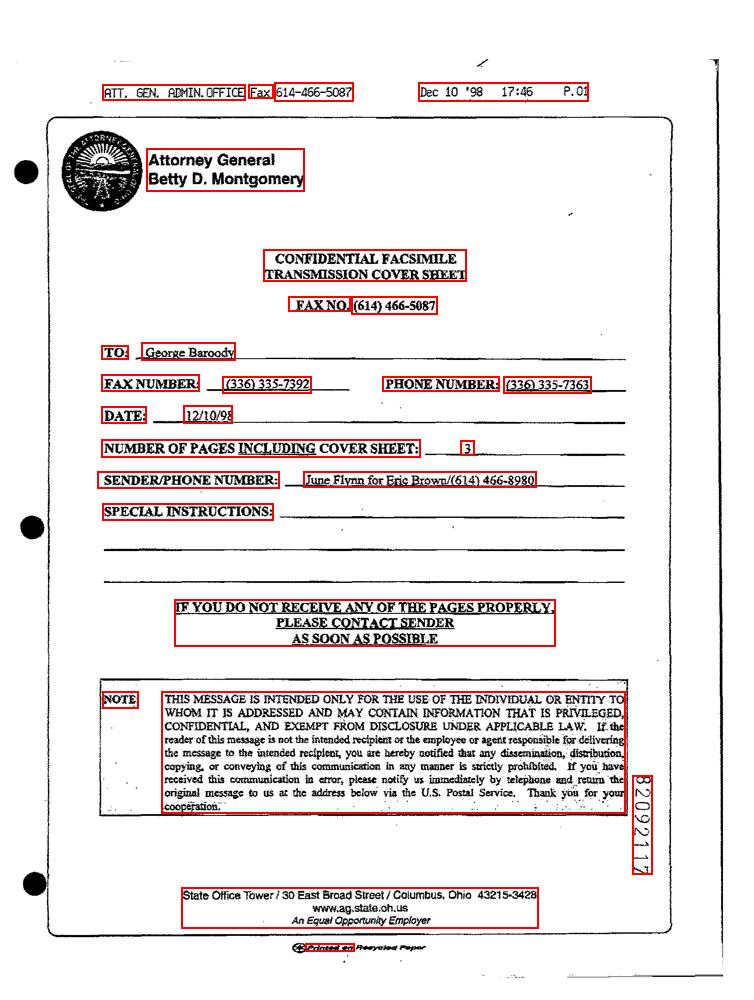

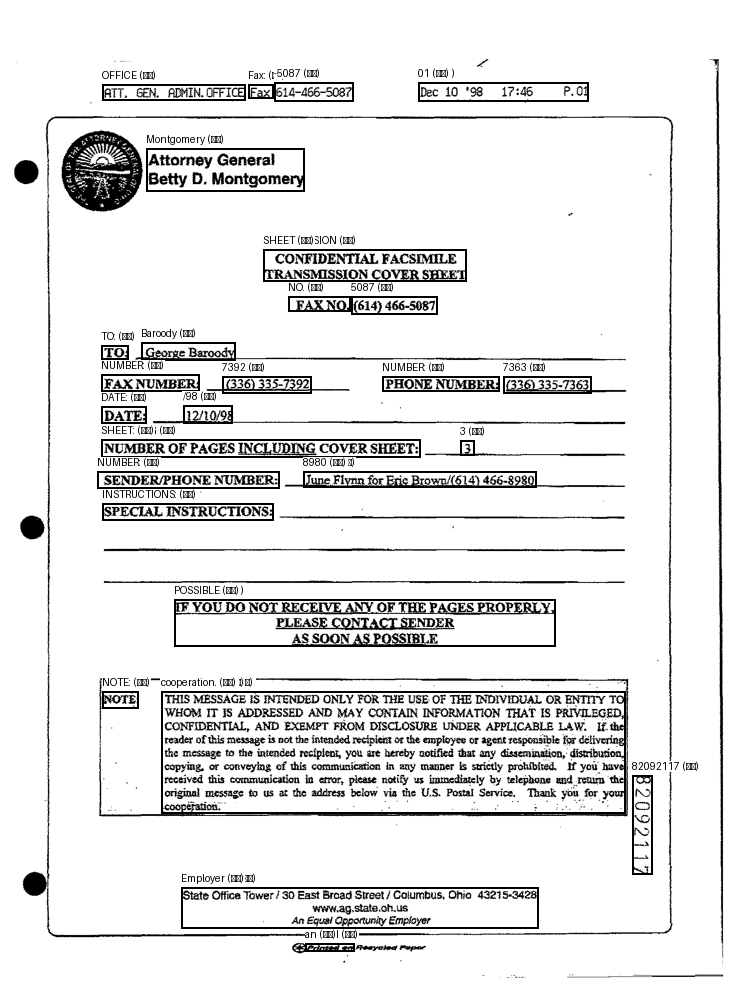

In [59]:

def inference(image, words, boxes):
    """
    参数：
        image: 图像对象
        words：一个列表，待进行序列标注的文本token
        boxes: words列表的每个token在图像image的"检测框"的位置信息
    return：一个列表word_labels，元素对应 words的每个token的标注标签
    """
    # 打印边界框样例，用于调试
    print(f"模型输入边界框样例: {boxes[0]}")
    
    # 确保所有边界框都是归一化到0-1000范围的，处理器内部会有变换
    # 但我们需要确保输入时已经归一化到预期范围
    # 获取图像尺寸，考虑不同的图像格式
    if hasattr(image, 'size'):  # PIL图像
        width, height = image.size
    elif hasattr(image, 'shape'):  # NumPy数组
        if len(image.shape) == 3:  # 彩色图像 (高度, 宽度, 通道)
            height, width = image.shape[0], image.shape[1]
        else:  # 灰度图像或其他格式
            height, width = image.shape[0], image.shape[1]
    else:
        # 如果无法获取尺寸，尝试将图像转换为PIL图像
        try:
            from PIL import Image
            if not isinstance(image, Image.Image):
                image_pil = Image.fromarray(image)
                width, height = image_pil.size
            else:
                width, height = image.size
        except Exception as e:
            print(f"无法获取图像尺寸: {e}")
            # 如果无法确定尺寸并且边界框已经是归一化的，可以跳过归一化步骤
            if all(box[0] <= 1000 and box[1] <= 1000 and box[2] <= 1000 and box[3] <= 1000 for box in boxes):
                print("假设边界框已经归一化")
                width, height = 1000, 1000  # 用于调试
            else:
                raise ValueError("无法确定图像尺寸，无法归一化边界框")
    
    print(f"图像尺寸: 宽度={width}, 高度={height}")
    
    # 检查边界框格式，确保已经归一化
    first_box = boxes[0]
    if max(first_box) > 1000:
        # 如果边界框不是归一化的，进行归一化
        print("警告：输入边界框未归一化，正在进行归一化...")
        normalized_boxes = []
        for box in boxes:
            normalized_boxes.append([
                int(1000 * (box[0] / width)),
                int(1000 * (box[1] / height)),
                int(1000 * (box[2] / width)),
                int(1000 * (box[3] / height)),
            ])
        boxes = normalized_boxes
        print(f"归一化后边界框样例: {boxes[0]}")
    
    # 若加载 processor 时 apply_ocr=True，此时只需传输 图像数据即可，processor内部会对输入图像image进行OCR识别
    encoded_inputs = processor_infer(image, words, boxes=boxes,    # boxes 和 words应该分别是 OCR 的检测阶段和文本识别阶段得到的结果 
                                 word_labels = [-1] * len(words),  # 因为实际的token标签还未知（待模型预测出来），所以这里统一用 -1 代替
                                 padding='max_length', truncation=True, return_tensors="np")  # 这里不能直接通过设置return_tensors='ms'输出Tensor
    
    # 打印处理后的边界框样例，用于调试
    if 'bbox' in encoded_inputs:
        print(f"处理器输出边界框样例: {encoded_inputs['bbox'][0][0]}")
    
    # 对LayoutLMv3所需的输入进行转换
    input_ids = Tensor(encoded_inputs['input_ids'])
    attention_mask = Tensor(encoded_inputs['attention_mask'])
    bbox = Tensor(encoded_inputs['bbox'])
    pixel_values = Tensor(encoded_inputs['pixel_values'])  # v3使用pixel_values而非image
    
    model_infer.set_train(False)
    # forward pass
    outputs = model_infer(
        input_ids=input_ids, 
        attention_mask=attention_mask, 
        bbox=bbox, 
        pixel_values=pixel_values  # 使用pixel_values
    )
    
    # 模型预测的标签的id
    prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
    
    # 模型对每个token（包含特殊标记作用的token）的id都预测出了对应的标签id，注意后续取出实际预测的token标签时跳过特殊token（开始、结束、填充等标记）的标签
    labels = encoded_inputs['labels'].squeeze().tolist()
    label_special = labels[0]  # 特殊标记的标签，一般为-100
    
    # 获取预测的words每个token元素对应的文本标注
    prediction_labels = [id2label[label_pred_id] for gt, label_pred_id in zip(labels, prediction_indices) if gt != label_special]
    
    return prediction_labels

# 准备模拟OCR函数
def draw_rectangle(image, boxes: list = []):
    """
    绘制图像image的文本矩阵框，boxes的每个元素为[x1,y1,x3,y3]
    return 绘制了文本框的图像
    """
    # 深度拷贝
    copied_image_array = np.array(image)
    copied_image_deep = Image.fromarray(copied_image_array)
    draw = ImageDraw.Draw(copied_image_deep, "RGBA")   

    font = ImageFont.load_default()

    for box in boxes:
        # 确保边界框坐标为整数
        box_coords = [int(coord) for coord in box]
        # 使用draw.rectangle()方法在图片上绘制矩形框
        draw.rectangle(box_coords, outline='#FF0000', width=2)
    
    return copied_image_deep

# 从测试集中获取一个样本进行推理
sample_idx = 0  # 可以选择任意样本索引

# 获取原始图像、文本和边界框
image = eval_funsd_dataset.images[sample_idx]
words = eval_funsd_dataset.tokens[sample_idx]
boxes = eval_funsd_dataset.boxes[sample_idx]

# 将图像转换为PIL图像
image_pil = Image.fromarray(image)

# 如果需要，对边界框进行归一化处理
def normalize_bbox(bbox, width, height):
    """
    归一化边界框坐标到0-1000范围内
    注意：确保坐标顺序是 [x_min, y_min, x_max, y_max]
    """
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

# 检查边界框是否已经归一化（通常FUNSD数据集中的边界框已经归一化，但为了安全起见）
width, height = image_pil.size
first_box = boxes[0]
is_normalized = True
if max(first_box) > 1000:  # 如果有值大于1000，可能需要归一化
    normalized_boxes = [normalize_bbox(box, width, height) for box in boxes]
    is_normalized = False
else:
    normalized_boxes = boxes.copy()  # 使用复制以避免修改原始数据

# 计算反归一化的边界框，用于显示
denormalized_boxes = []
for box in normalized_boxes:
    denorm_box = [
        int(box[0] * width / 1000),
        int(box[1] * height / 1000),
        int(box[2] * width / 1000),
        int(box[3] * height / 1000)
    ]
    denormalized_boxes.append(denorm_box)

# 绘制反归一化边界框 - 使用从归一化边界框计算回来的边界框
img_with_rectangles = draw_rectangle(image_pil, denormalized_boxes)

# 尝试推理并捕获可能的错误
try:
    predicted_labels = inference(image, words, normalized_boxes)
    
    # 打印结果
    print("文本:", words)
    print("预测标签:", predicted_labels)
    print("边界框是否已归一化:", is_normalized)
    print("边界框例子:", boxes[0])
    print("归一化边界框例子:", normalized_boxes[0])
    print("反归一化边界框例子:", denormalized_boxes[0])
    
    # 打印标签统计
    from collections import Counter
    label_counts = Counter(predicted_labels)
    print("标签统计:", dict(label_counts))
    
    # 创建带标签的可视化图像 - 使用反归一化的边界框坐标
    visualization = visualize_predictions(image_pil, denormalized_boxes, words, predicted_labels)
except Exception as e:
    
    # 如果没有成功得到预测标签，创建一个空的标签列表
    predicted_labels = ["未知"] * len(words)
    visualization = visualize_predictions(image_pil, denormalized_boxes, words, predicted_labels)

# 显示图像（如果在支持显示的环境中）
img_with_rectangles.show()

# 可选：保存带标注的图像
output_dir = "./LayoutLMv3/results"
import os
os.makedirs(output_dir, exist_ok=True)
img_with_rectangles.save(f"{output_dir}/sample_{sample_idx}_prediction.png")

# 将预测标签可视化在图像上
def visualize_predictions(image, boxes, words, labels):
    """
    在图像上可视化文本和对应的标签
    
    Args:
        image: PIL图像
        boxes: 边界框坐标列表（原始像素坐标，非归一化）
        words: 文本列表
        labels: 标签列表
    
    Returns:
        带有标注的PIL图像
    """
    # 深度拷贝图像
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)
    
    # 尝试加载字体，如果失败则使用默认字体
    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = ImageFont.load_default()
    
    # 颜色映射 - 为不同标签类型设置不同颜色
    color_map = {
        'O': '#000000',  # 黑色
        'B-HEADER': '#FF0000',  # 红色
        'I-HEADER': '#FF3333',  # 浅红色
        'B-QUESTION': '#0000FF',  # 蓝色
        'I-QUESTION': '#3333FF',  # 浅蓝色
        'B-ANSWER': '#00FF00',  # 绿色
        'I-ANSWER': '#33FF33',  # 浅绿色
    }
    
    # 绘制边界框和标签
    for box, word, label in zip(boxes, words, labels):
        # 确保边界框坐标为整数
        box_coords = [int(coord) for coord in box]
        
        # 绘制边界框
        color = color_map.get(label, '#000000')
        draw.rectangle(box_coords, outline=color, width=2)
        
        # 绘制标签和文本
        text = f"{word} ({label})"
        text_position = (box_coords[0], max(0, box_coords[1] - 15))  # 在边界框上方显示，但不超出图像
        
        # 绘制背景矩形以增强文本可读性
        text_bbox = draw.textbbox(text_position, text, font=font)
        draw.rectangle(text_bbox, fill='white')
        
        # 绘制文本
        draw.text(text_position, text, fill=color, font=font)
    
    return img_copy

# 创建带标签的可视化图像 - 使用反归一化的边界框坐标
visualization = visualize_predictions(image_pil, denormalized_boxes, words, predicted_labels)

# 保存可视化结果
visualization.save(f"{output_dir}/sample_{sample_idx}_visualization.png")

# 显示可视化结果（如果在支持显示的环境中）
visualization.show()


让我们只比较标签不是-100的位置的预测和标签。我们还希望有这些（非标准化）的边界框：

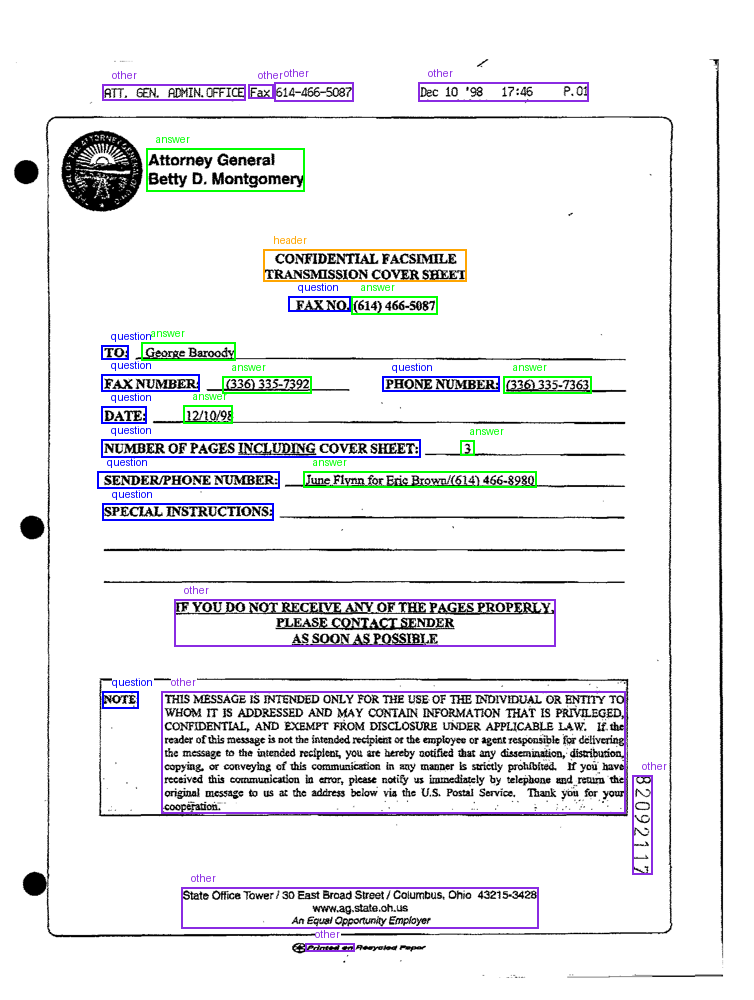

高级可视化已保存到 ./LayoutLMv3/results/sample_0_advanced_viz.png


In [60]:
def unnormalize_box(bbox, width, height):
    """
    将归一化的边界框转换回原始坐标
    
    Args:
        bbox: 归一化的边界框坐标 [x_min, y_min, x_max, y_max]
        width: 图像宽度
        height: 图像高度
        
    Returns:
        反归一化的边界框坐标
    """
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

def iob_to_label(label):
    """
    将IOB格式的标签转换为简单标签
    
    Args:
        label: IOB格式的标签，如'B-HEADER'或'O'
        
    Returns:
        简单标签，如'header'或'other'
    """
    # 处理'O'标签
    if label == 'O':
        return 'other'
    
    # 处理B-和I-格式的标签
    if label.startswith('B-') or label.startswith('I-'):
        label = label[2:]  # 去掉B-或I-前缀
    
    if not label:
        return 'other'
    return label.lower()

def visualize_advanced(image, boxes, predictions, labels=None):
    """
    在图像上可视化文本和预测标签，更高级的版本
    
    Args:
        image: PIL图像
        boxes: 归一化的边界框坐标列表
        predictions: 预测的标签列表
        labels: 真实标签列表，如果有的话
        
    Returns:
        带有标注的PIL图像
    """
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)
    
    width, height = image.size
    
    # 定义标签到颜色的映射
    label2color = {
        'question': '#0000FF',  # 蓝色
        'answer': '#00FF00',    # 绿色
        'header': '#FFA500',    # 橙色
        'other': '#8A2BE2'      # 紫色
    }
    
    # 尝试加载字体
    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = ImageFont.load_default()
    
    # 反归一化边界框并绘制标签
    for i, (box, prediction) in enumerate(zip(boxes, predictions)):
        # 反归一化边界框
        denorm_box = unnormalize_box(box, width, height)
        denorm_box = [int(coord) for coord in denorm_box]  # 转换为整数
        
        # 获取简化后的标签和对应的颜色
        predicted_label = iob_to_label(prediction)
        color = label2color.get(predicted_label, '#000000')
        
        # 绘制边界框
        draw.rectangle(denorm_box, outline=color, width=2)
        
        # 在边界框上方显示标签
        text_position = (denorm_box[0] + 10, max(0, denorm_box[1] - 15))
        
        # 绘制背景矩形以增强文本可读性
        text_bbox = draw.textbbox(text_position, predicted_label, font=font)
        draw.rectangle(text_bbox, fill='white')
        
        # 绘制标签文本
        draw.text(text_position, predicted_label, fill=color, font=font)
    
    return img_copy

# 尝试使用新的可视化函数
try:
    # 获取需要的数据
    encoded_inputs = processor_infer(image, words, boxes=normalized_boxes, 
                                    word_labels = [-1] * len(words),
                                    padding='max_length', truncation=True, return_tensors="np")
    
    # 获取token级别的边界框
    token_boxes = encoded_inputs['bbox'].squeeze().tolist()
    
    # 获取对应的标签（-100是填充标签）
    labels = encoded_inputs['labels'].squeeze().tolist()
    
    # 处理预测结果
    model_infer.set_train(False)
    input_ids = Tensor(encoded_inputs['input_ids'])
    attention_mask = Tensor(encoded_inputs['attention_mask'])
    bbox = Tensor(encoded_inputs['bbox'])
    pixel_values = Tensor(encoded_inputs['pixel_values'])
    
    outputs = model_infer(
        input_ids=input_ids, 
        attention_mask=attention_mask, 
        bbox=bbox, 
        pixel_values=pixel_values
    )
    
    # 获取预测结果
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    
    # 过滤掉填充标签
    true_predictions = [id2label[pred] for pred, label in zip(predictions, labels) if label != -100]
    true_boxes = [box for box, label in zip(token_boxes, labels) if label != -100]
    
    # 创建高级可视化
    advanced_viz = visualize_advanced(image_pil, true_boxes, true_predictions)
    
    # 保存和显示结果
    advanced_viz.save(f"{output_dir}/sample_{sample_idx}_advanced_viz.png")
    advanced_viz.show()
    
    print(f"高级可视化已保存到 {output_dir}/sample_{sample_idx}_advanced_viz.png")
    
except Exception as e:
    print(f"高级可视化过程中出现错误: {e}")




将此与真实标签进行比较：

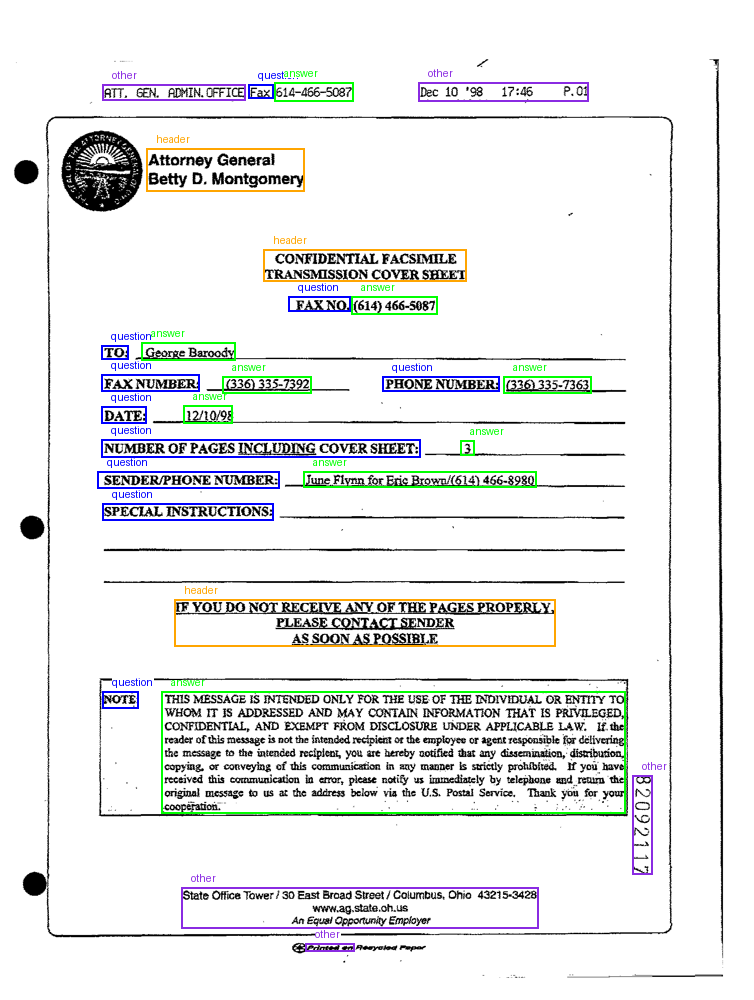

In [58]:

# 添加比较功能: 比较预测结果与真实标签
def compare_predictions_with_ground_truth(image, example, id2label, width=None, height=None):
    """
    在图像上可视化预测结果与真实标签的比较
    
    Args:
        image: PIL图像
        example: 数据样本，包含tokens、bboxes和ner_tags
        id2label: 标签id到标签文本的映射
        width: 图像宽度，如果为None则从图像获取
        height: 图像高度，如果为None则从图像获取
    
    Returns:
        带有真实标签和预测标签的PIL图像
    """
    if width is None or height is None:
        width, height = image.size
    
    # 创建两个图像副本
    img_ground_truth = image.copy()
    draw_gt = ImageDraw.Draw(img_ground_truth)
    
    # 定义标签到颜色的映射
    label2color = {
        'question': '#0000FF',  # 蓝色
        'answer': '#00FF00',    # 绿色
        'header': '#FFA500',    # 橙色
        'other': '#8A2BE2'      # 紫色
    }
    
    # 尝试加载字体
    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = ImageFont.load_default()
    
    # 绘制真实标签
    for word, box, label_id in zip(example['tokens'], example['bboxes'], example['ner_tags']):
        # 反归一化边界框
        if max(box) <= 1000:  # 如果边界框已经归一化
            box = unnormalize_box(box, width, height)
        
        # 转换为整数坐标
        box = [int(coord) for coord in box]
        
        # 获取真实标签
        if isinstance(label_id, (int, float)):
            label_id = int(label_id)
            actual_label = iob_to_label(id2label[label_id])
        else:
            # 如果label_id已经是字符串
            actual_label = iob_to_label(label_id)
        
        # 获取颜色
        color = label2color.get(actual_label, '#000000')
        
        # 绘制边界框
        draw_gt.rectangle(box, outline=color, width=2)
        
        # 绘制标签
        text_position = (box[0] + 10, max(0, box[1] - 15))
        text_bbox = draw_gt.textbbox(text_position, actual_label, font=font)
        draw_gt.rectangle(text_bbox, fill='white')
        draw_gt.text(text_position, actual_label, fill=color, font=font)
    
    return img_ground_truth

# 尝试获取并显示真实标签
try:
    # 获取测试样本 - 这里直接使用test_dataset而不是test_dataset["test"]
    test_example = next(test_dataset.create_dict_iterator())
    sample_idx = 0
    
    # 获取测试样本中的图像和标签 - 直接使用我们已经准备好的数据
    example = {
        'image': eval_funsd_dataset.images[sample_idx],
        'tokens': eval_funsd_dataset.tokens[sample_idx],
        'bboxes': eval_funsd_dataset.boxes[sample_idx],
        'ner_tags': eval_funsd_dataset.labels[sample_idx]
    }
    
    # 将图像转换为PIL格式
    image_pil = Image.fromarray(example['image']).convert("RGB")
    width, height = image_pil.size
    
    # 创建真实标签可视化
    ground_truth_viz = compare_predictions_with_ground_truth(
        image_pil, 
        example, 
        id2label, 
        width, 
        height
    )
    
    # 保存真实标签可视化
    ground_truth_viz.save(f"{output_dir}/sample_{sample_idx}_ground_truth.png")
    ground_truth_viz.show()
    
except Exception as e:
    print(f"创建真实标签可视化时出错: {e}")
    import traceback
    traceback.print_exc()




## 注意：没有标签时的推理

上面的代码使用“标签”来确定哪些标记是否位于特定单词的开头。当然，在推理时，您无法访问任何标签。在这种情况下，您可以利用标记器返回的`offset_mapping`。